<a href="https://colab.research.google.com/github/p25-c4/kerly_project/blob/main/03_15_sy_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns


from sklearn.tree import export_graphviz
import graphviz
from subprocess import call
from IPython.display import Image


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind

from xgboost import plot_importance

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

# 팔레트 설정
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')

In [ ]:
matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
on_items = pd.read_csv("/content/drive/MyDrive/on_items.csv")
on_items.head()
on_orders = pd.read_csv("/content/drive/MyDrive/on_orders.csv")
on_orders.head()
on_users = pd.read_csv("/content/drive/MyDrive/on_users.csv",encoding='cp949')
on_users.head()

,idUser,Gender,Age,FamilyCount,MemberYN
0,U10001,여성,26,2,Y
1,U10002,남성,61,2,Y
2,U10003,여성,34,2,Y
3,U10004,남성,26,1,N
4,U10005,여성,33,3,Y


In [ ]:
on_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043272 entries, 0 to 1043271
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   idUser      1043272 non-null  object
 1   idOrder     1043272 non-null  object
 2   OrderDT     1043272 non-null  object
 3   ItemCode    1043272 non-null  object
 4   Price       1043272 non-null  int64 
 5   DeliveryDT  1043272 non-null  object
dtypes: int64(1), object(5)
memory usage: 47.8+ MB


In [ ]:
# Age 열을 기준으로 연령대별로 분류
bins = [19, 29, 39, 49, 59, 69]  # 연령대 경계값
labels = ['20s', '30s', '40s', '50s', '60s']  # 각 연령대에 해당하는 라벨
on_users['AgeGroup'] = pd.cut(on_users['Age'], bins=bins, labels=labels, right=True)
order_user = pd.merge(on_orders, on_users, on='idUser')
order_user.head(10)

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Gender,Age,FamilyCount,MemberYN,AgeGroup
0,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L1-M12-S0070-1113,17030,04DEC2021:03:26:00,여성,26,2,Y,20s
1,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L1-M15-S0140-1247,7680,04DEC2021:03:26:00,여성,26,2,Y,20s
2,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L1-M23-S0580-1047,12420,04DEC2021:03:26:00,여성,26,2,Y,20s
3,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L4-M12-S0640-1010,6250,04DEC2021:03:26:00,여성,26,2,Y,20s
4,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L4-M17-S0130-1018,14450,04DEC2021:03:26:00,여성,26,2,Y,20s
5,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L4-M17-S0530-1021,23350,04DEC2021:03:26:00,여성,26,2,Y,20s
6,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L4-M18-S0110-1012,11720,04DEC2021:03:26:00,여성,26,2,Y,20s
7,U10001,U10001-O2021-1002,07JAN2021:17:08:51,L1-M15-S0140-1323,22520,08JAN2021:06:24:00,여성,26,2,Y,20s
8,U10001,U10001-O2021-1002,07JAN2021:17:08:51,L1-M21-S0540-1082,3780,08JAN2021:06:24:00,여성,26,2,Y,20s
9,U10001,U10001-O2021-1002,07JAN2021:17:08:51,L4-M12-S0350-1036,21630,08JAN2021:06:24:00,여성,26,2,Y,20s


In [ ]:
# OrderDT 열을 datetime 객체로 변환
order_user['OrderDT'] = pd.to_datetime(order_user['OrderDT'], format='%d%b%Y:%H:%M:%S')

# datetime 객체에서 년을 추출하여 새로운 컬럼 Month에 저장
order_user['Year'] = order_user['OrderDT'].dt.year
# datetime 객체에서 월을 추출하여 새로운 컬럼 Month에 저장
order_user['Month'] = order_user['OrderDT'].dt.month
# datetime 객체에서 일을 추출하여 새로운 컬럼 Month에 저장
order_user['Day'] = order_user['OrderDT'].dt.day
# datetime 객체에서 시를 추출하여 새로운 컬럼 Month에 저장
order_user['Hour'] = order_user['OrderDT'].dt.hour
order_user.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Gender,Age,FamilyCount,MemberYN,AgeGroup,Year,Month,Day,Hour
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,04DEC2021:03:26:00,여성,26,2,Y,20s,2021,12,3,20
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,04DEC2021:03:26:00,여성,26,2,Y,20s,2021,12,3,20
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,04DEC2021:03:26:00,여성,26,2,Y,20s,2021,12,3,20
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,04DEC2021:03:26:00,여성,26,2,Y,20s,2021,12,3,20
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,04DEC2021:03:26:00,여성,26,2,Y,20s,2021,12,3,20


In [ ]:
total_data = pd.merge(order_user, on_items, on='ItemCode')
total_data.head(10)

# list of not food --> 시간 오래 걸렸음
not_food = ["냄비", "기계", "디스펜서", "퍼즐", "냉장고", "밀폐용기",
            "액자", "수동 반죽펴기", "채칼", "캔따기", "모자",
            "카지노","용기","케이스","만두통", "바람개비", "레깅스", "수박 나무라고요",
            "스텐 상추바구니 2호 야채 튀김 과일 바스켓 채반",
            "스테인레스 상추바구니 1호 메쉬바구니 소쿠리 채반",
            "스텐 타공상추바구니 2호","수박과도 大 (10개묶음) 0151","양상추 1cm 샌들 슬리퍼  JG6 (7157830)",
            "후르츠커버포켓크로스백(수박)", "양상추 여름 블라우스 JAP60 (7271217)", "양상추 여자 슬랙스 BF33 (7416269)",
            "양상추 여자 여름샌들 JK131 (7162818)", "MT124 A4 참외색 매직터치 두성 180g 10매입 X ( 3세트 )",
            "에이프릴래빗 양상추 스트링 빅포켓 숏야상점퍼 MA0906 (6660376)", "사랑에 빠진 과일토퍼 - 참외",
            "[총알배송] 제오닉 화채 수박통 8L 채반 믹싱볼 샐러드볼 판촉물 답례품 사은",
            "익사이팅 컬러링토이 유화물감 스포츠 스포츠 참외",
            "[하프클럽/한샘]SOK 프레시 여름 사각 수박용기 4L 2P",
            "참외 모형 1P (소)", "양상추키우기 7종", "양상추키우기 7종 채소키우기", "나 채소",
            "초 가을 계절 개성 캐쥬얼 참외 껍질 쿨링 여성", "22511712S3488857739", "타공 상추 바구니 2호 과일채소 씻어 빠른건조 주방",
            "OBSESSION 100g150g200g250g300g Kabura Bullet 금속 지그 헤드 오징어 어시", "나혼자키운다(대파)",
            "밀폐용기 42호 3L 2P세트 수박보관통 과일 대파 냉장고수납 야채 냉동실정리", "양파 대파 감자 마늘 생강 조개 과일망 메시 메쉬 그물망 일자형"
            ]
len(not_food)

# ItemName에 not_food의 값이 포함된 경우 추출
not_food_order_item = total_data[total_data['ItemName'].apply(lambda x: any(item for item in not_food if item in x))]
print(not_food_order_item.shape)
not_food_order_item.head()

# order_item_df 에서 not_food 제거
data = total_data.drop(index = not_food_order_item.index)
data.head()

(60210, 25)


,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Gender,Age,FamilyCount,MemberYN,...,ItemLargeCode,ItemLargeName,ItemMiddleCode,ItemMiddleName,ItemSmallCode,ItemSmallName,ItemName,PriceYear,PriceMin,PriceMax
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,04DEC2021:03:26:00,여성,26,2,Y,...,L1,가공식품,M12,과일,S0070,과일,이츠웰 후르츠칵테일 과일통조림 3K 슬라이스,2021,16880,17900
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,04DEC2021:03:26:00,여성,26,2,Y,...,L1,가공식품,M12,과일,S0070,과일,이츠웰 후르츠칵테일 과일통조림 3K 슬라이스,2022,17580,18650
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,04DEC2021:03:26:00,여성,26,2,Y,...,L1,가공식품,M12,과일,S0070,과일,이츠웰 후르츠칵테일 과일통조림 3K 슬라이스,2023,18310,19630
3,U10047,U10047-O2021-1027,2021-02-02 14:07:24,L1-M12-S0070-1113,17300,03FEB2021:03:17:00,남성,55,0,Y,...,L1,가공식품,M12,과일,S0070,과일,이츠웰 후르츠칵테일 과일통조림 3K 슬라이스,2021,16880,17900
4,U10047,U10047-O2021-1027,2021-02-02 14:07:24,L1-M12-S0070-1113,17300,03FEB2021:03:17:00,남성,55,0,Y,...,L1,가공식품,M12,과일,S0070,과일,이츠웰 후르츠칵테일 과일통조림 3K 슬라이스,2022,17580,18650


In [ ]:
print(len(not_food))

44


In [ ]:
data.shape

(2748146, 25)

<Axes: xlabel='AgeGroup', ylabel='Count'>

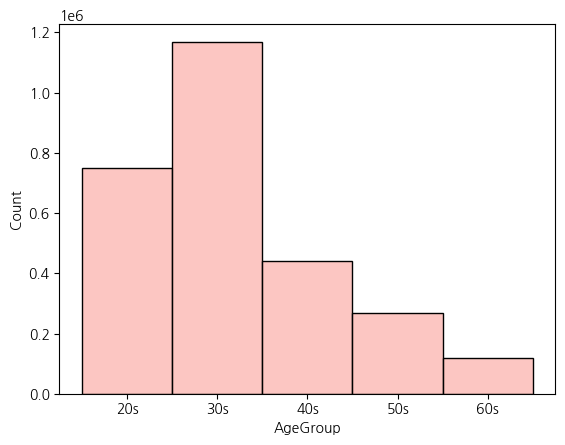

In [ ]:
sns.histplot(data = data, x='AgeGroup')

<Axes: xlabel='Year', ylabel='count'>

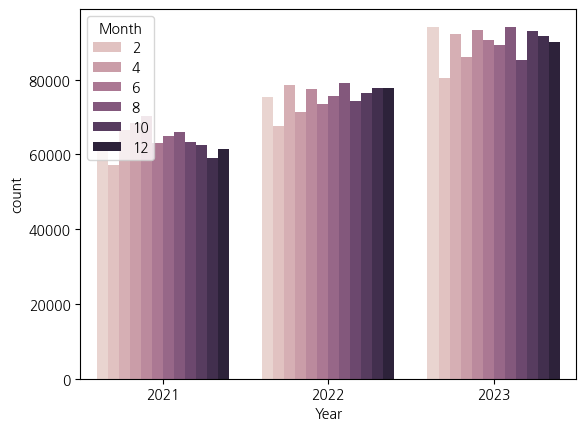

In [ ]:
sns.countplot(data = data, x='Year', hue = 'Month')

1월에 행사를 많이 하기 때문에 2월 매출이 현저히 낮다.  
1월에 매출이 가장 높음  
5월에 가정의 날이니까 많이 구매, 행사도 많이 함  

In [1]:
sns.histplot(data = data, x='Gender')

NameError: name 'sns' is not defined

<Axes: xlabel='MemberYN', ylabel='Count'>

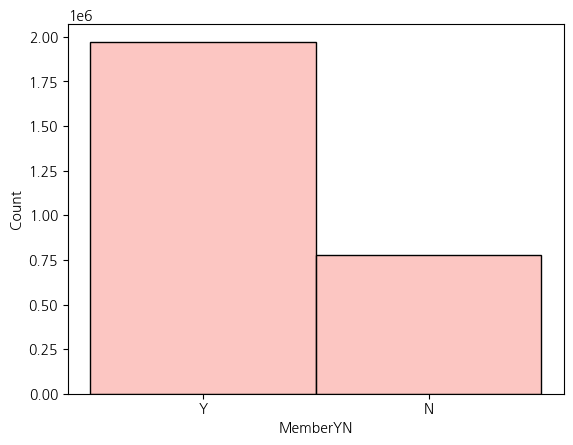

In [ ]:
sns.histplot(data = data, x='MemberYN')

<Axes: xlabel='Gender', ylabel='count'>

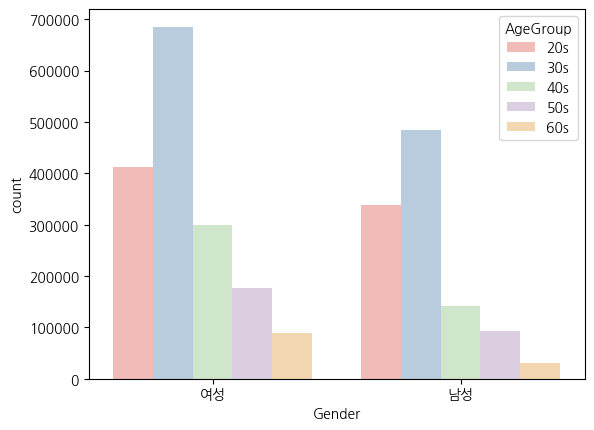

In [ ]:
sns.countplot(data = data, x='Gender', hue = 'AgeGroup')

<Axes: xlabel='Gender', ylabel='count'>

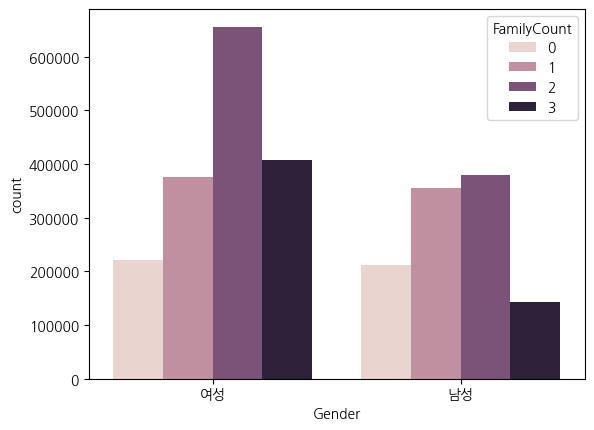

In [ ]:
sns.countplot(data = data, x='Gender', hue = 'FamilㄷyCount')

<Axes: xlabel='AgeGroup', ylabel='count'>

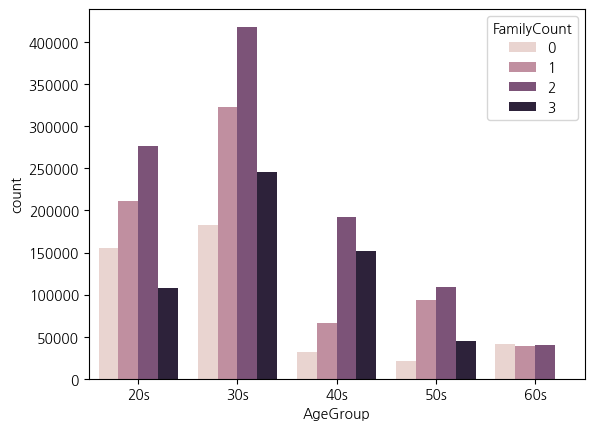

In [ ]:
sns.countplot(data = data, x='AgeGroup', hue = 'FamilyCount')

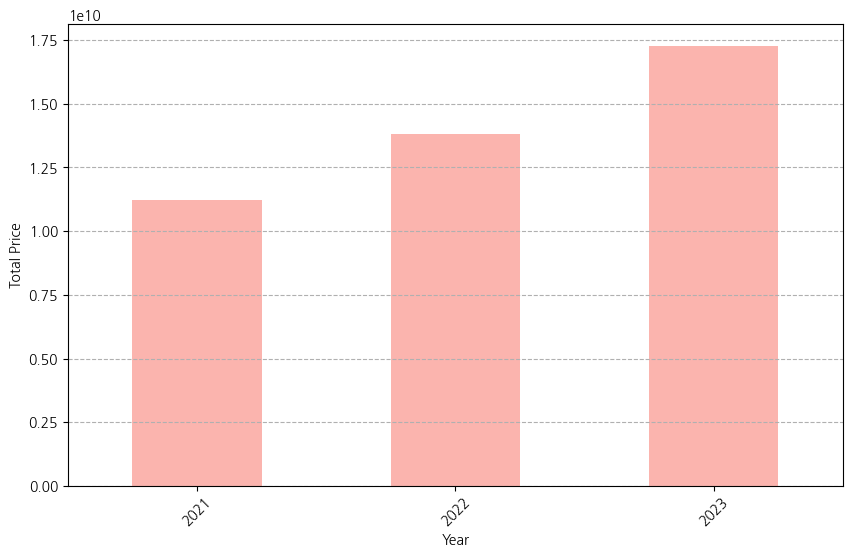

In [ ]:
age_group_price_sum = data.groupby('Year')['Price'].sum()
plt.figure(figsize=(10, 6))
age_group_price_sum.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Total Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

<Axes: xlabel='ItemLargeName', ylabel='count'>

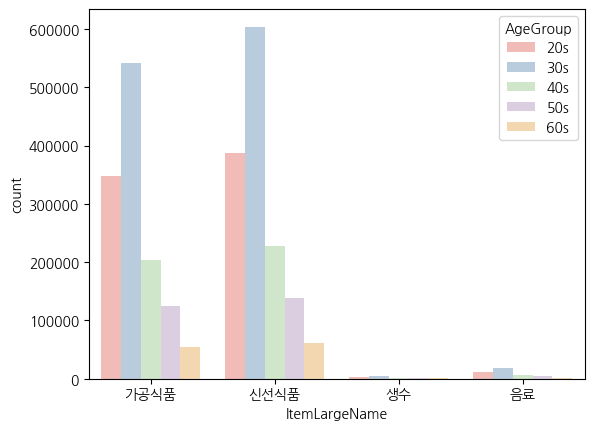

In [ ]:
sns.countplot(data = data, x='ItemLargeName', hue = 'AgeGroup')


<Axes: xlabel='ItemLargeName', ylabel='count'>

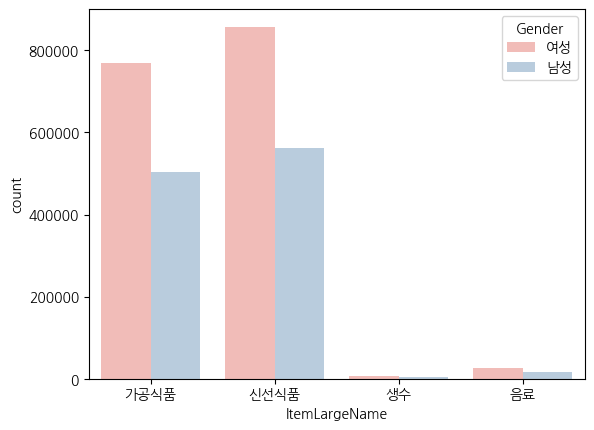

In [ ]:
sns.countplot(data = data, x='ItemLargeName', hue = 'Gender')

<Axes: xlabel='ItemMiddleName', ylabel='count'>

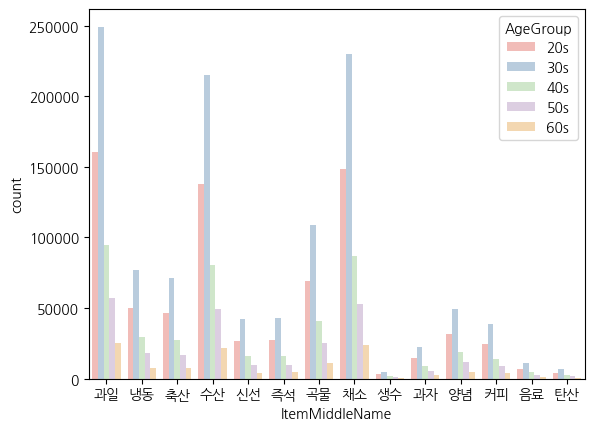

In [ ]:
sns.countplot(data = data, x='ItemMiddleName', hue = 'AgeGroup')

<Axes: xlabel='ItemMiddleName', ylabel='count'>

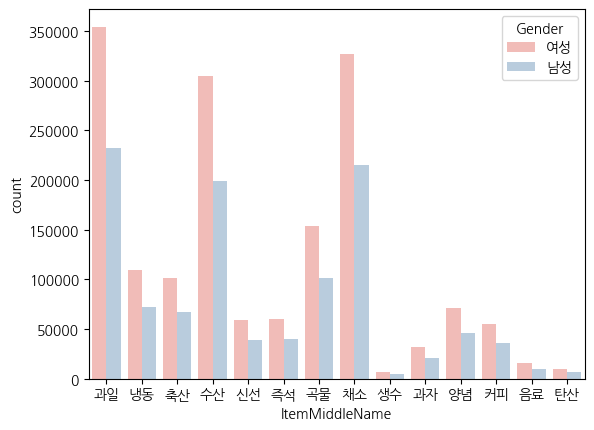

In [ ]:
sns.countplot(data = data, x='ItemMiddleName', hue = 'Gender')

<Axes: xlabel='ItemSmallName', ylabel='count'>

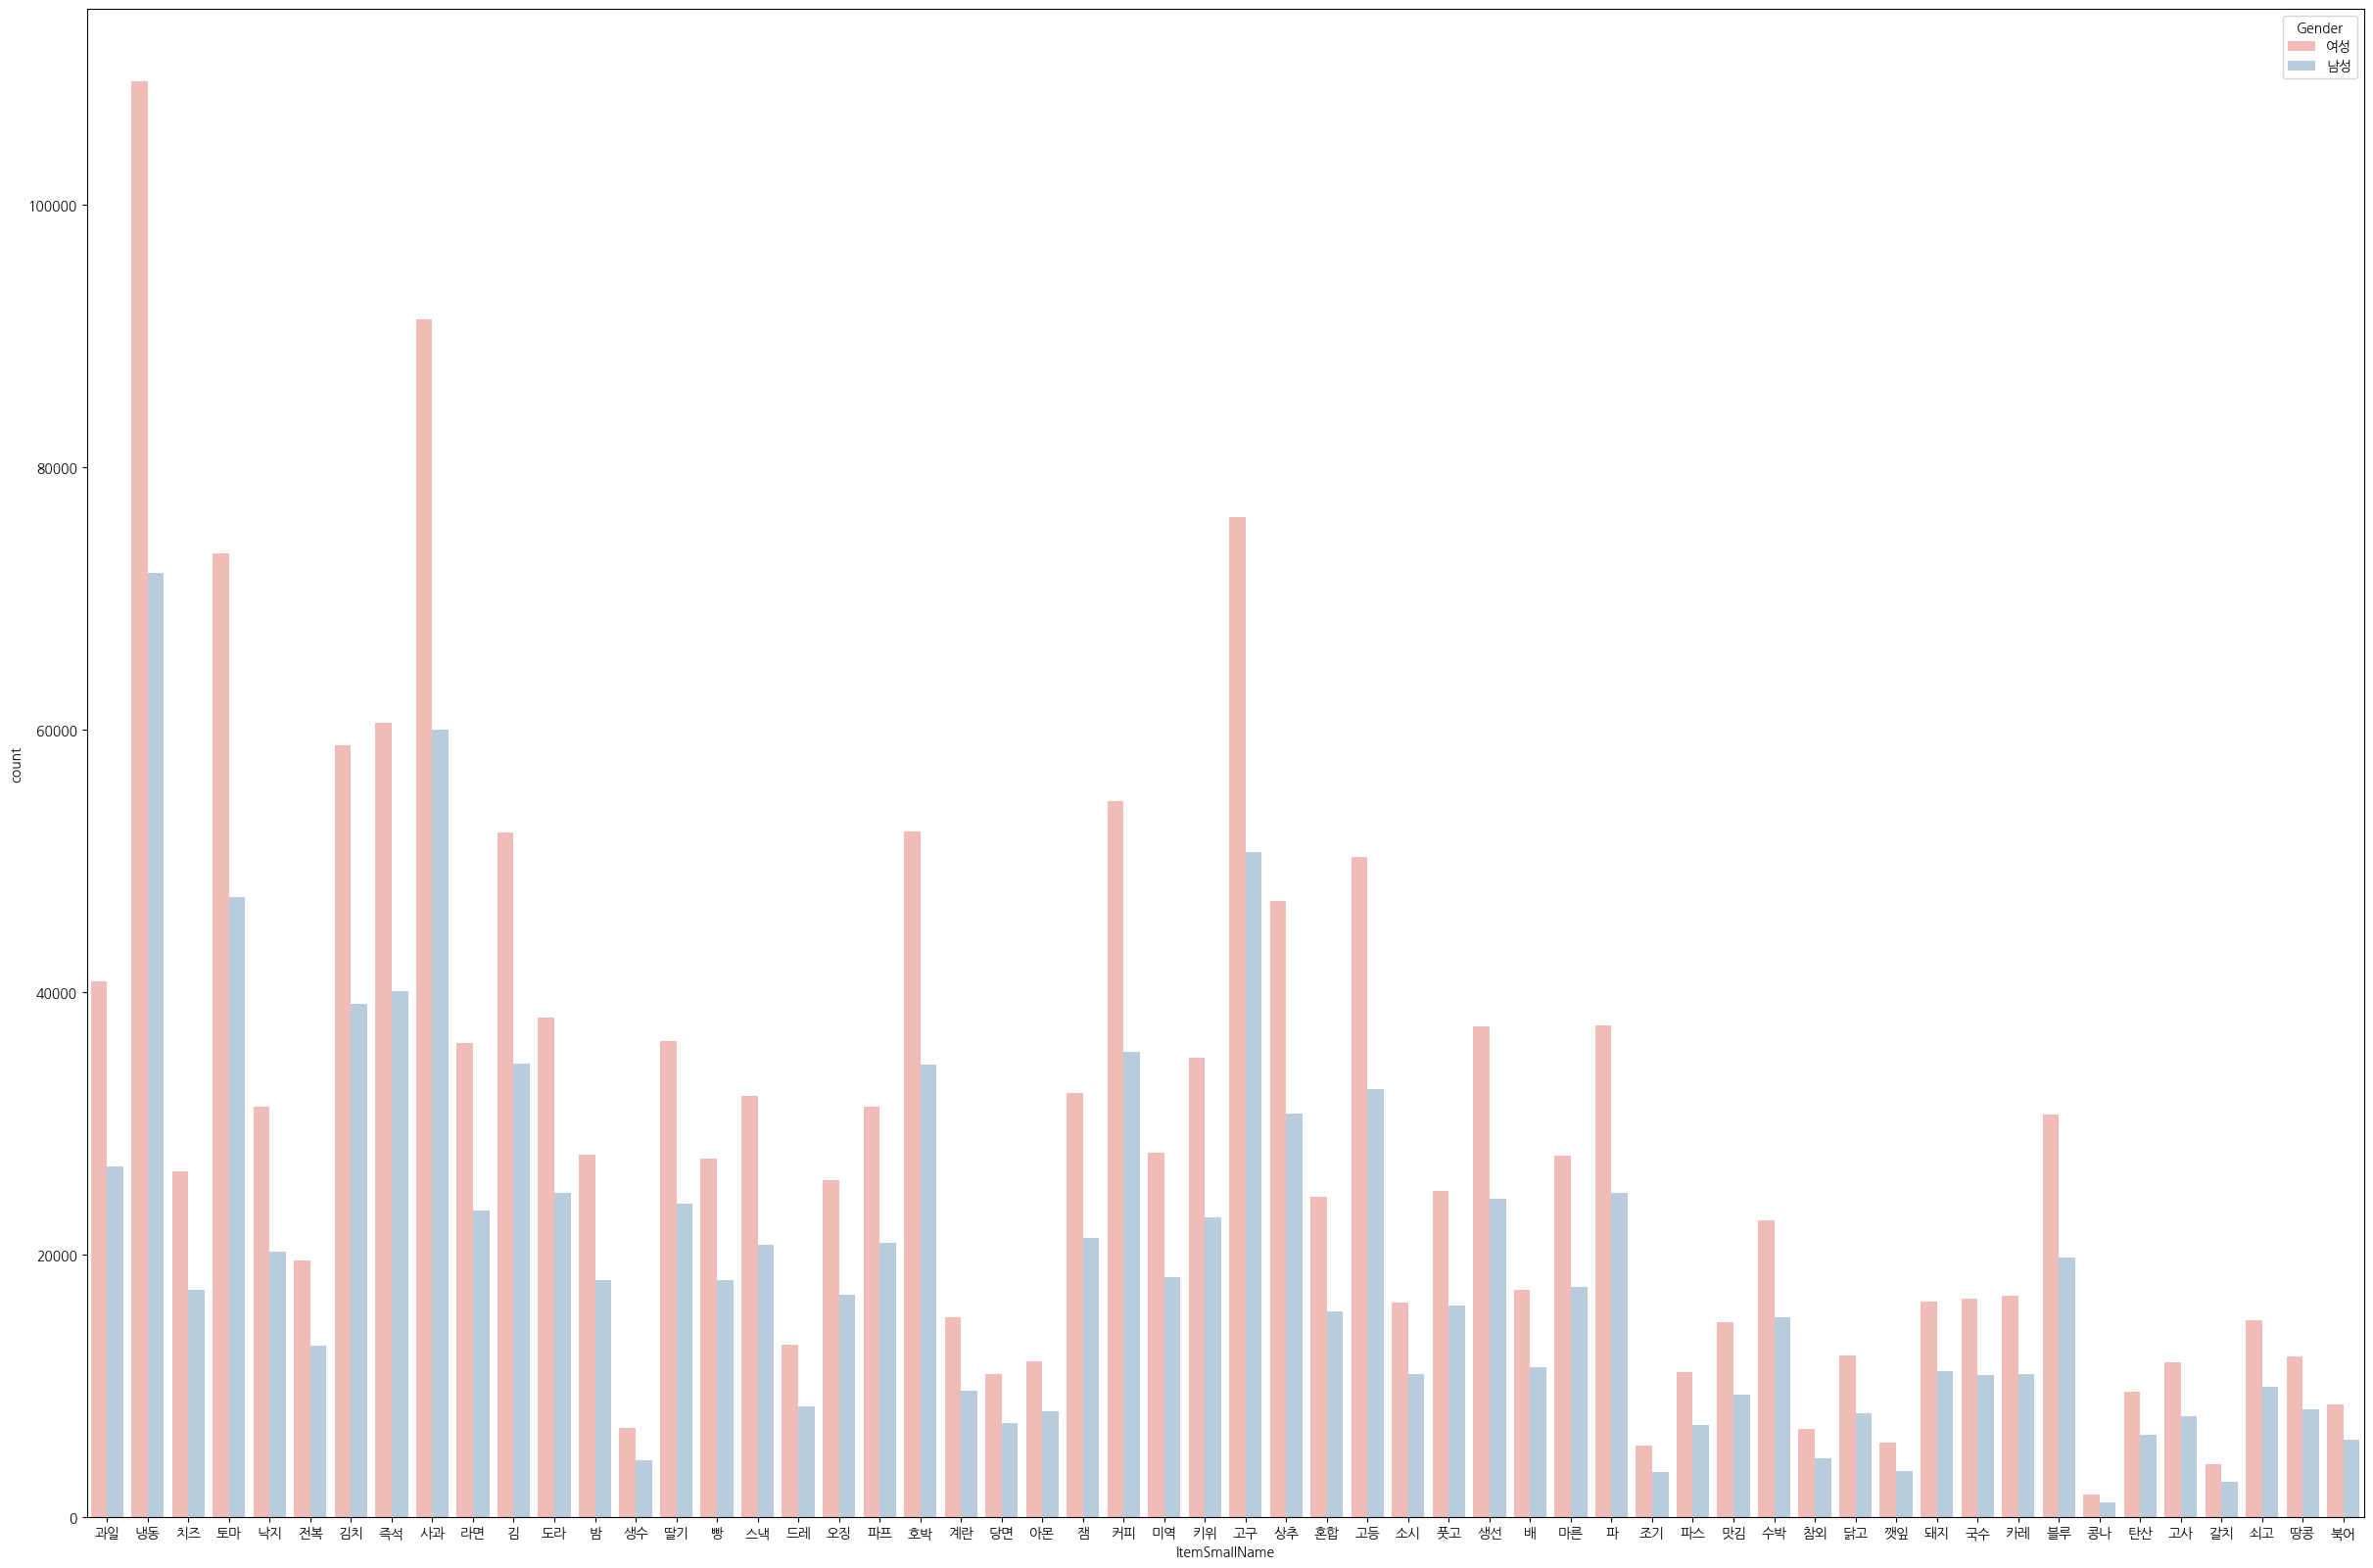

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'Gender')

<Axes: xlabel='ItemSmallName', ylabel='count'>

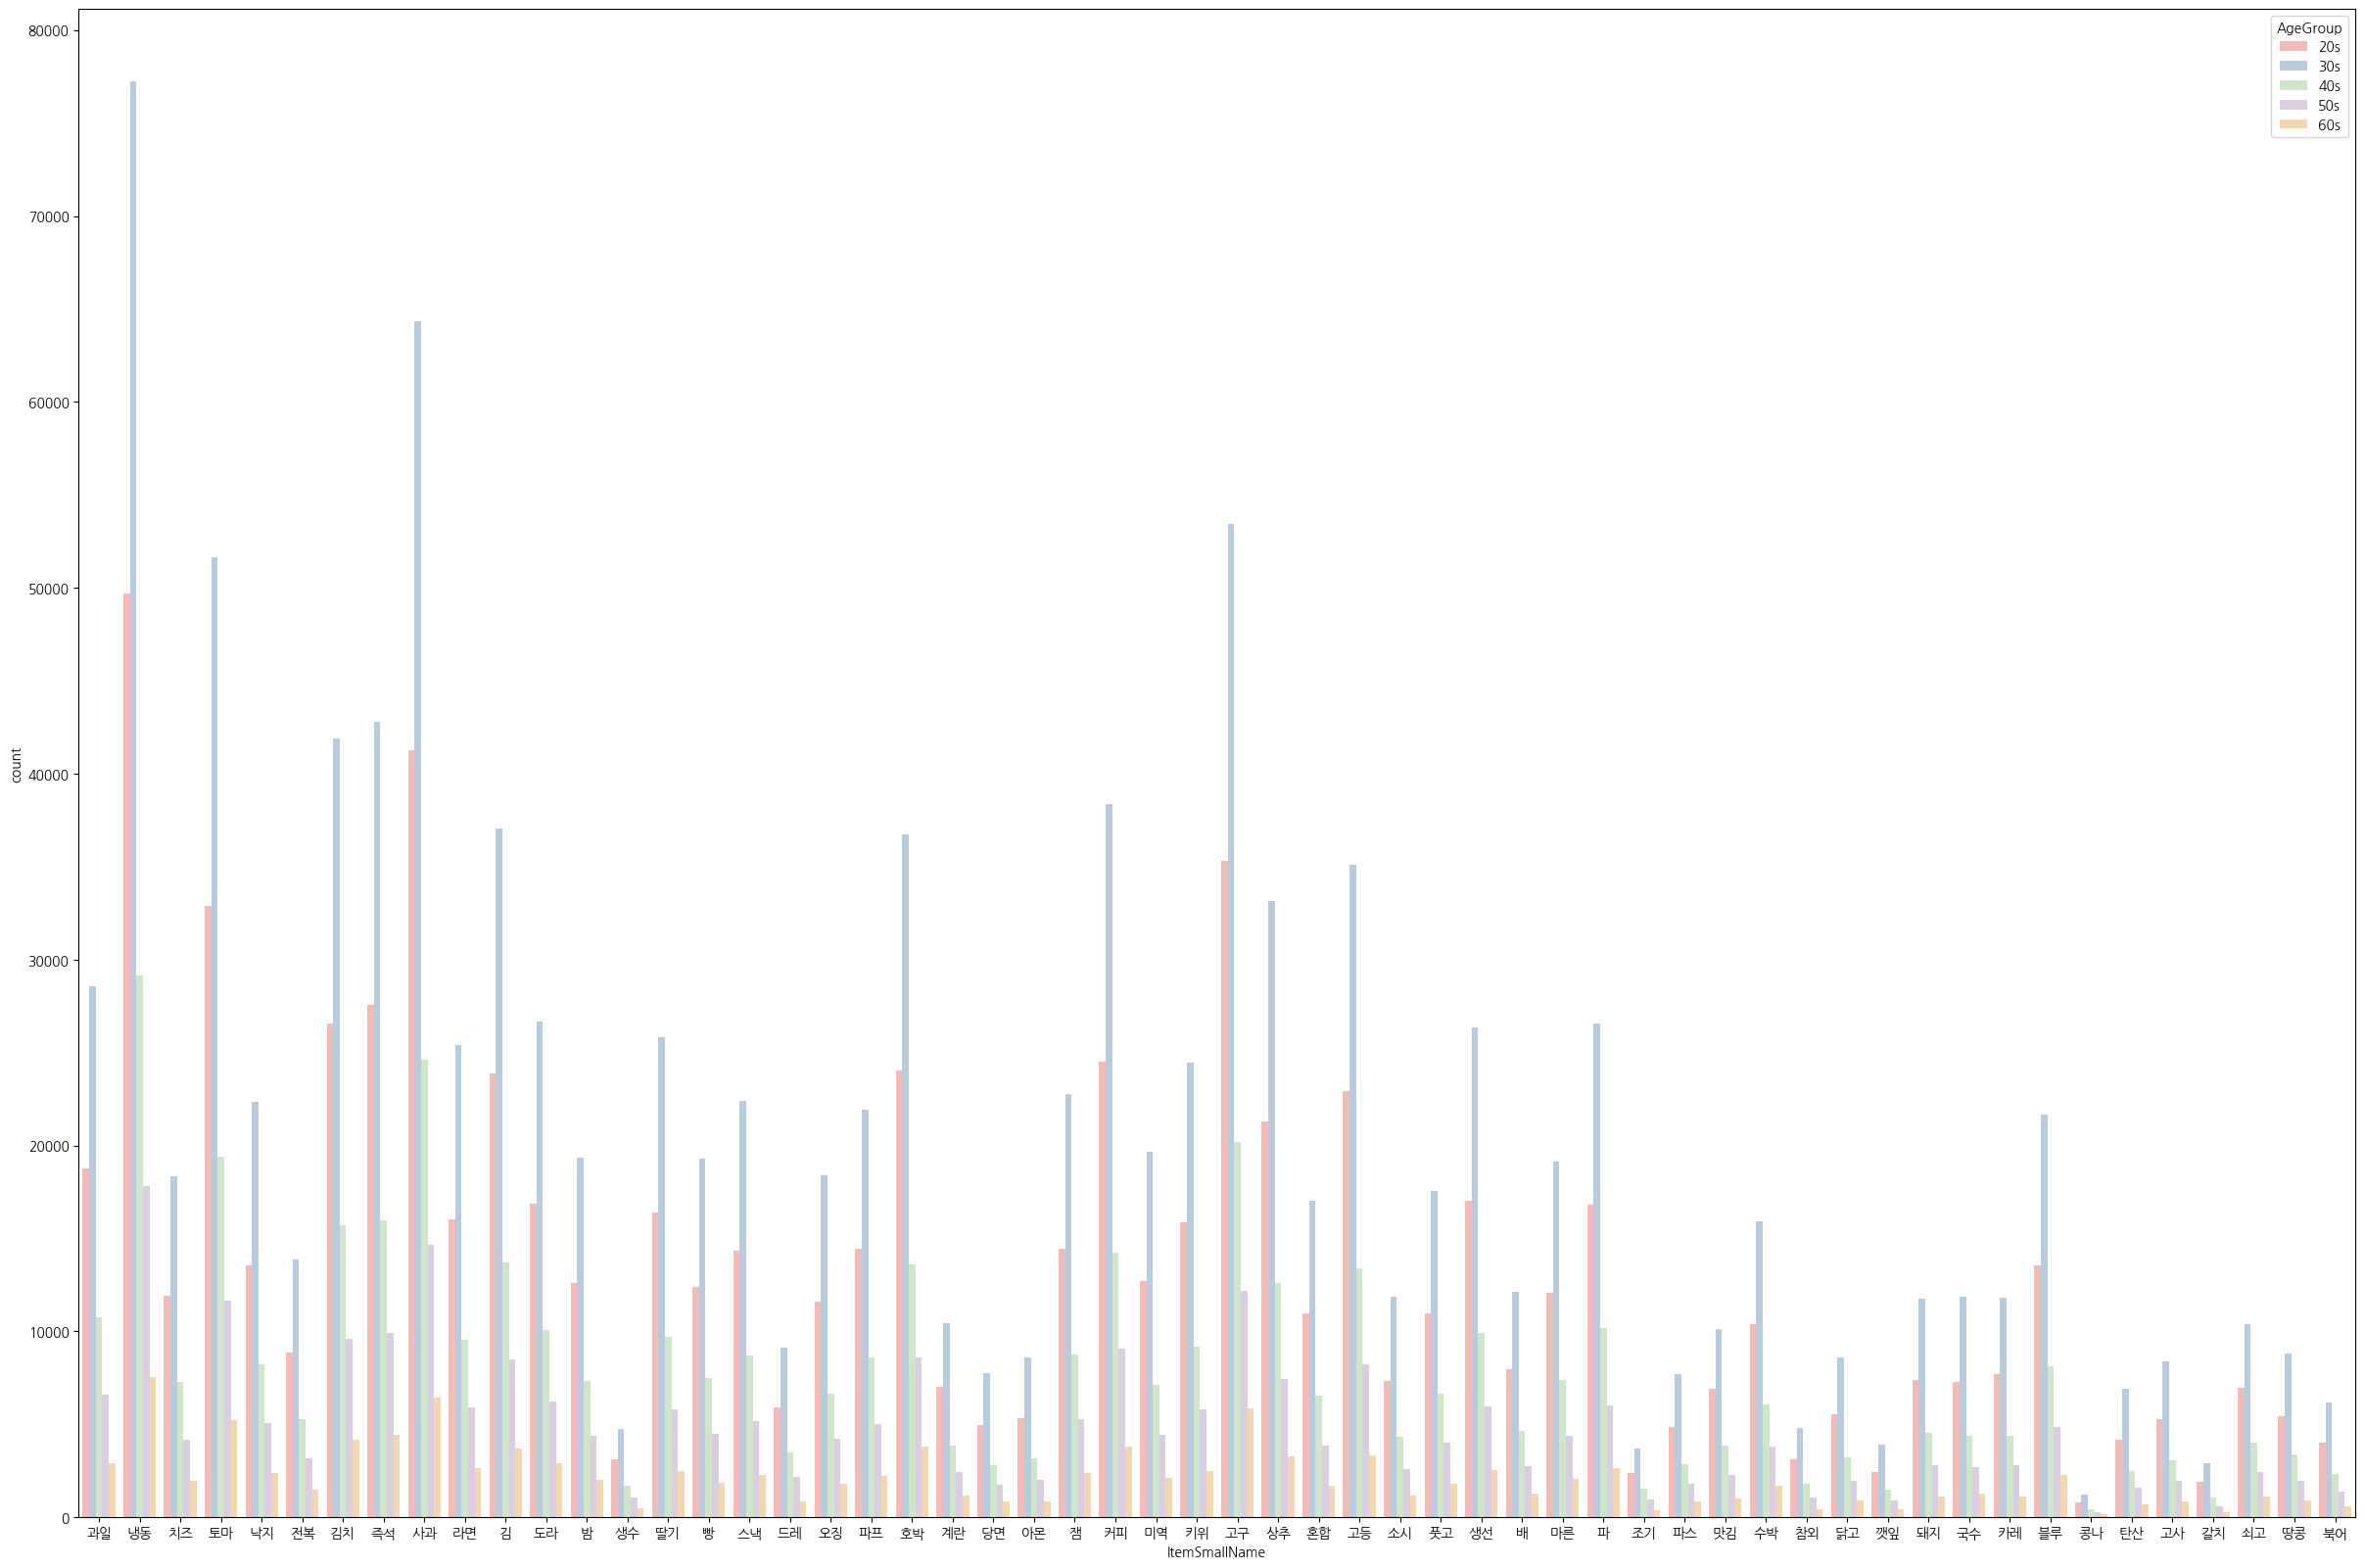

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'AgeGroup')

<Axes: xlabel='ItemSmallName', ylabel='count'>

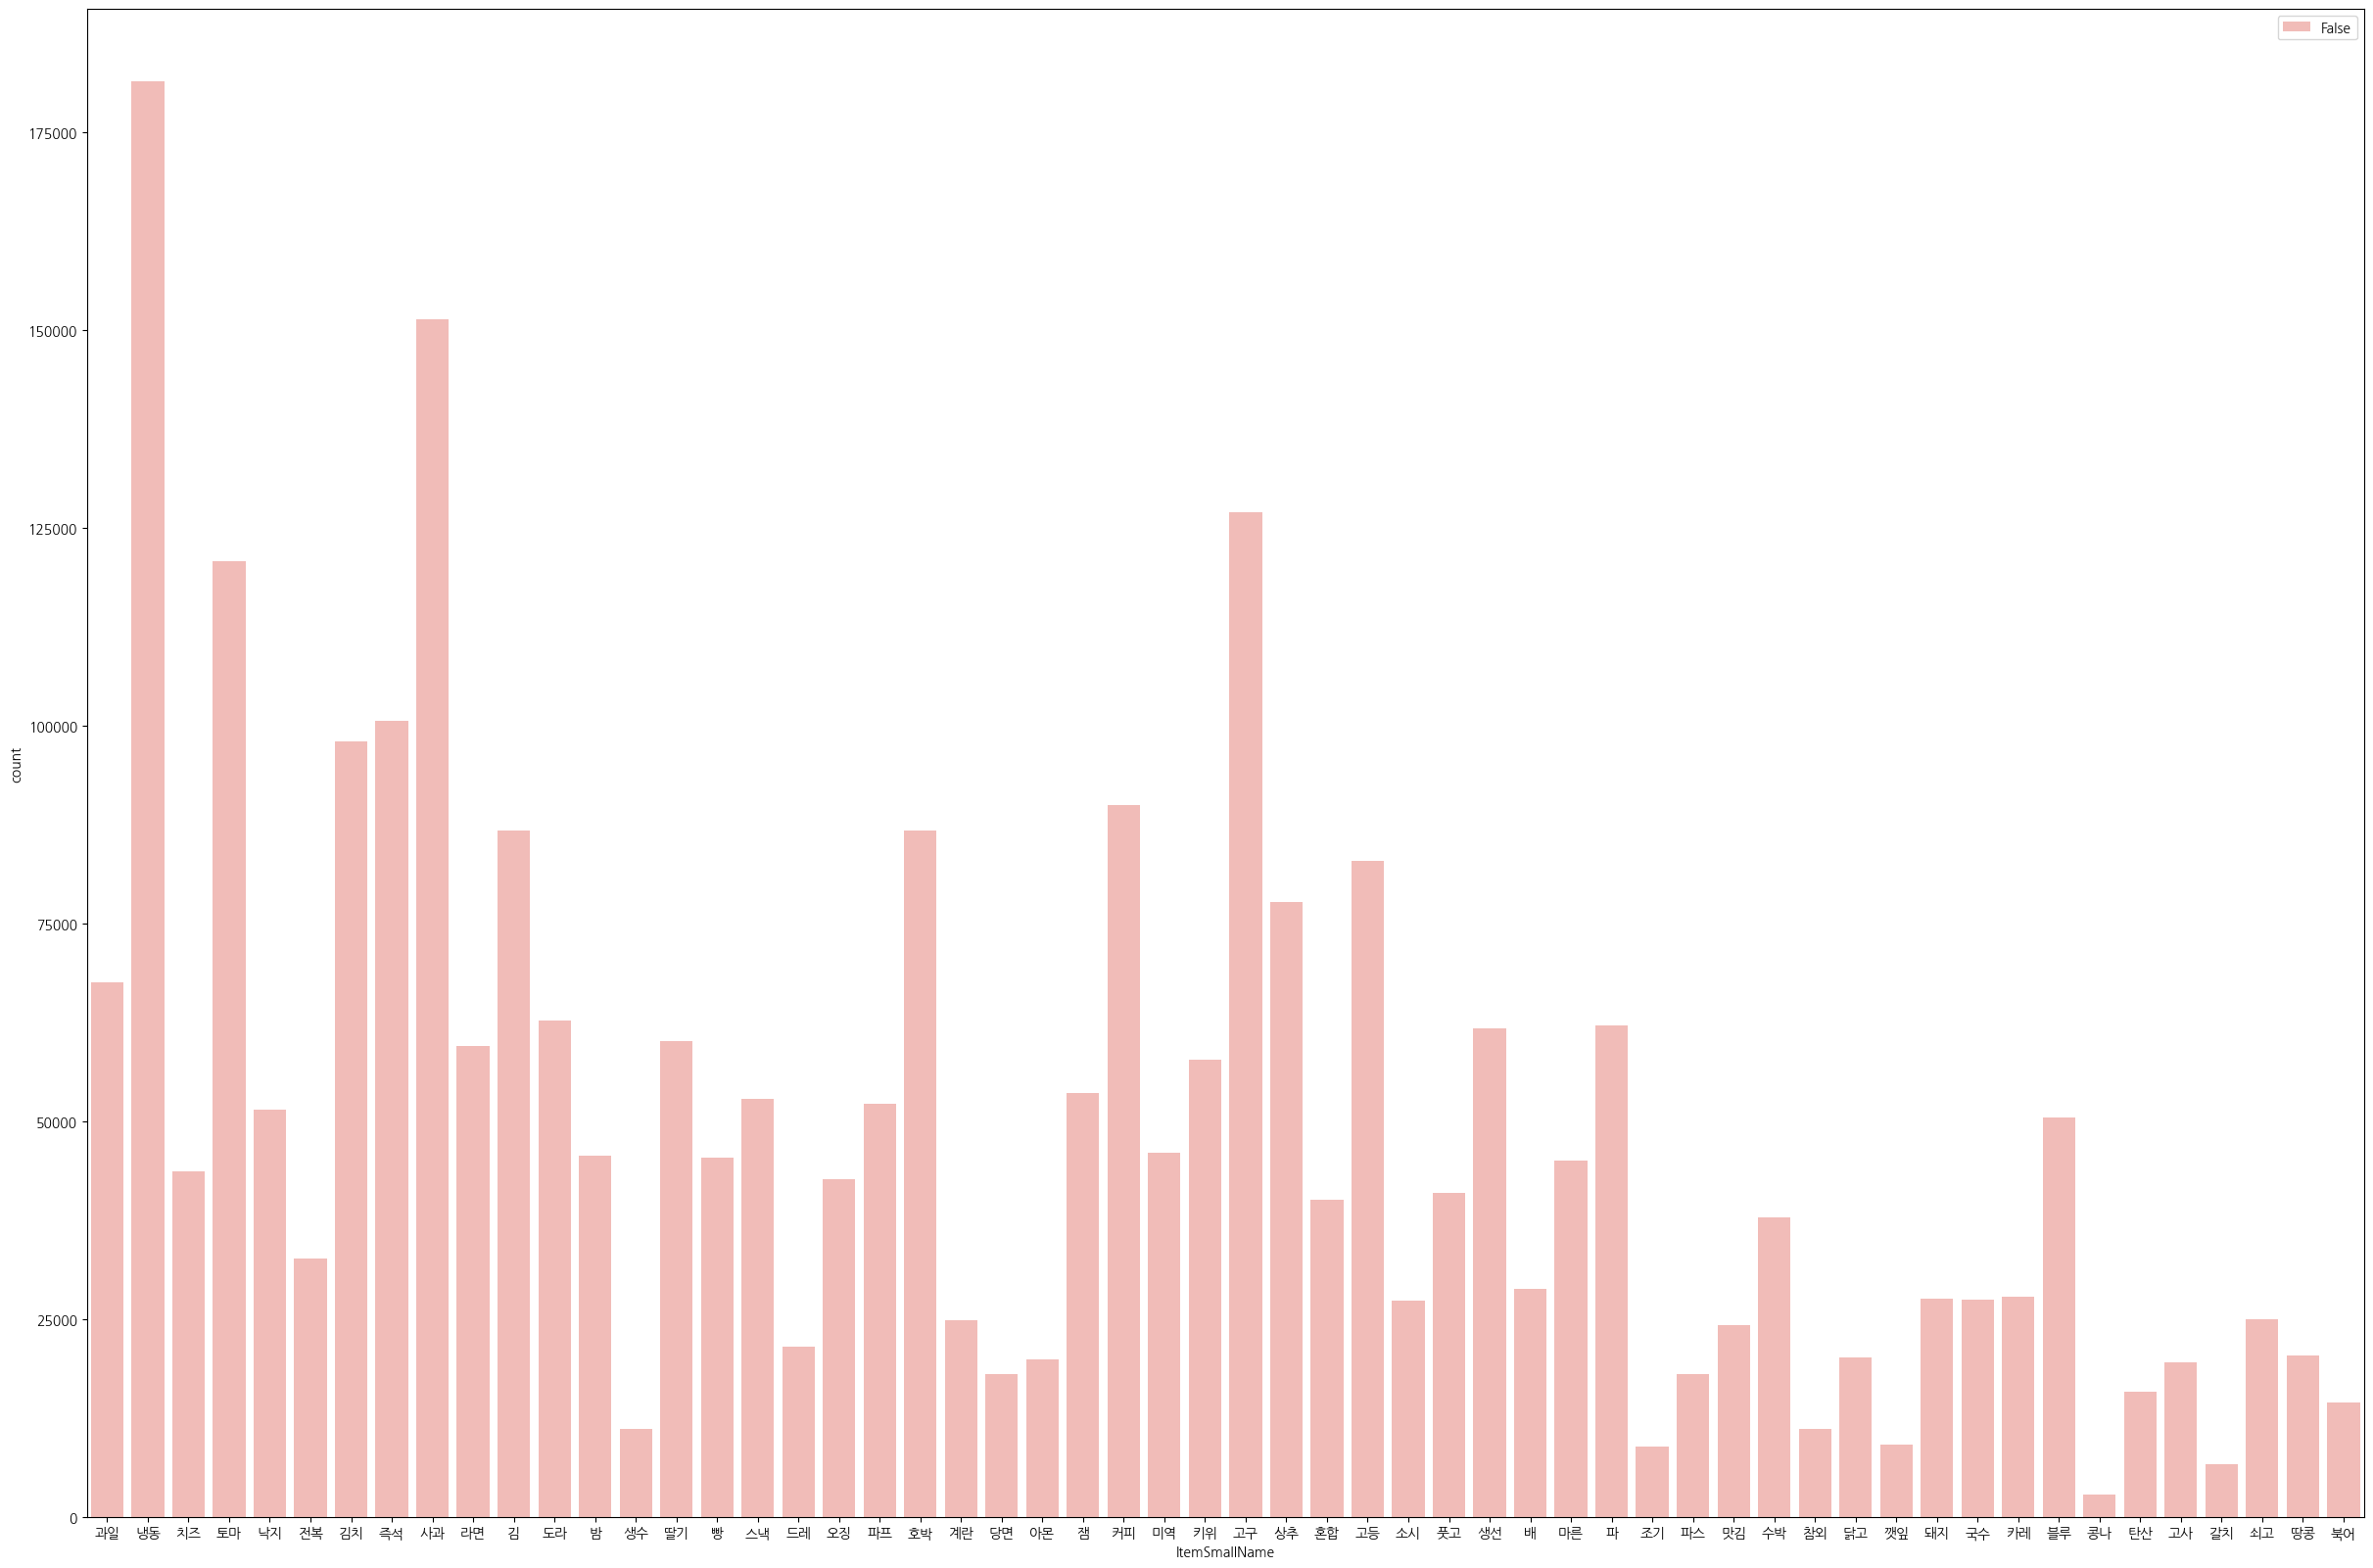

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'AgeGroup'=='[20s]')

<Axes: xlabel='ItemSmallName', ylabel='count'>

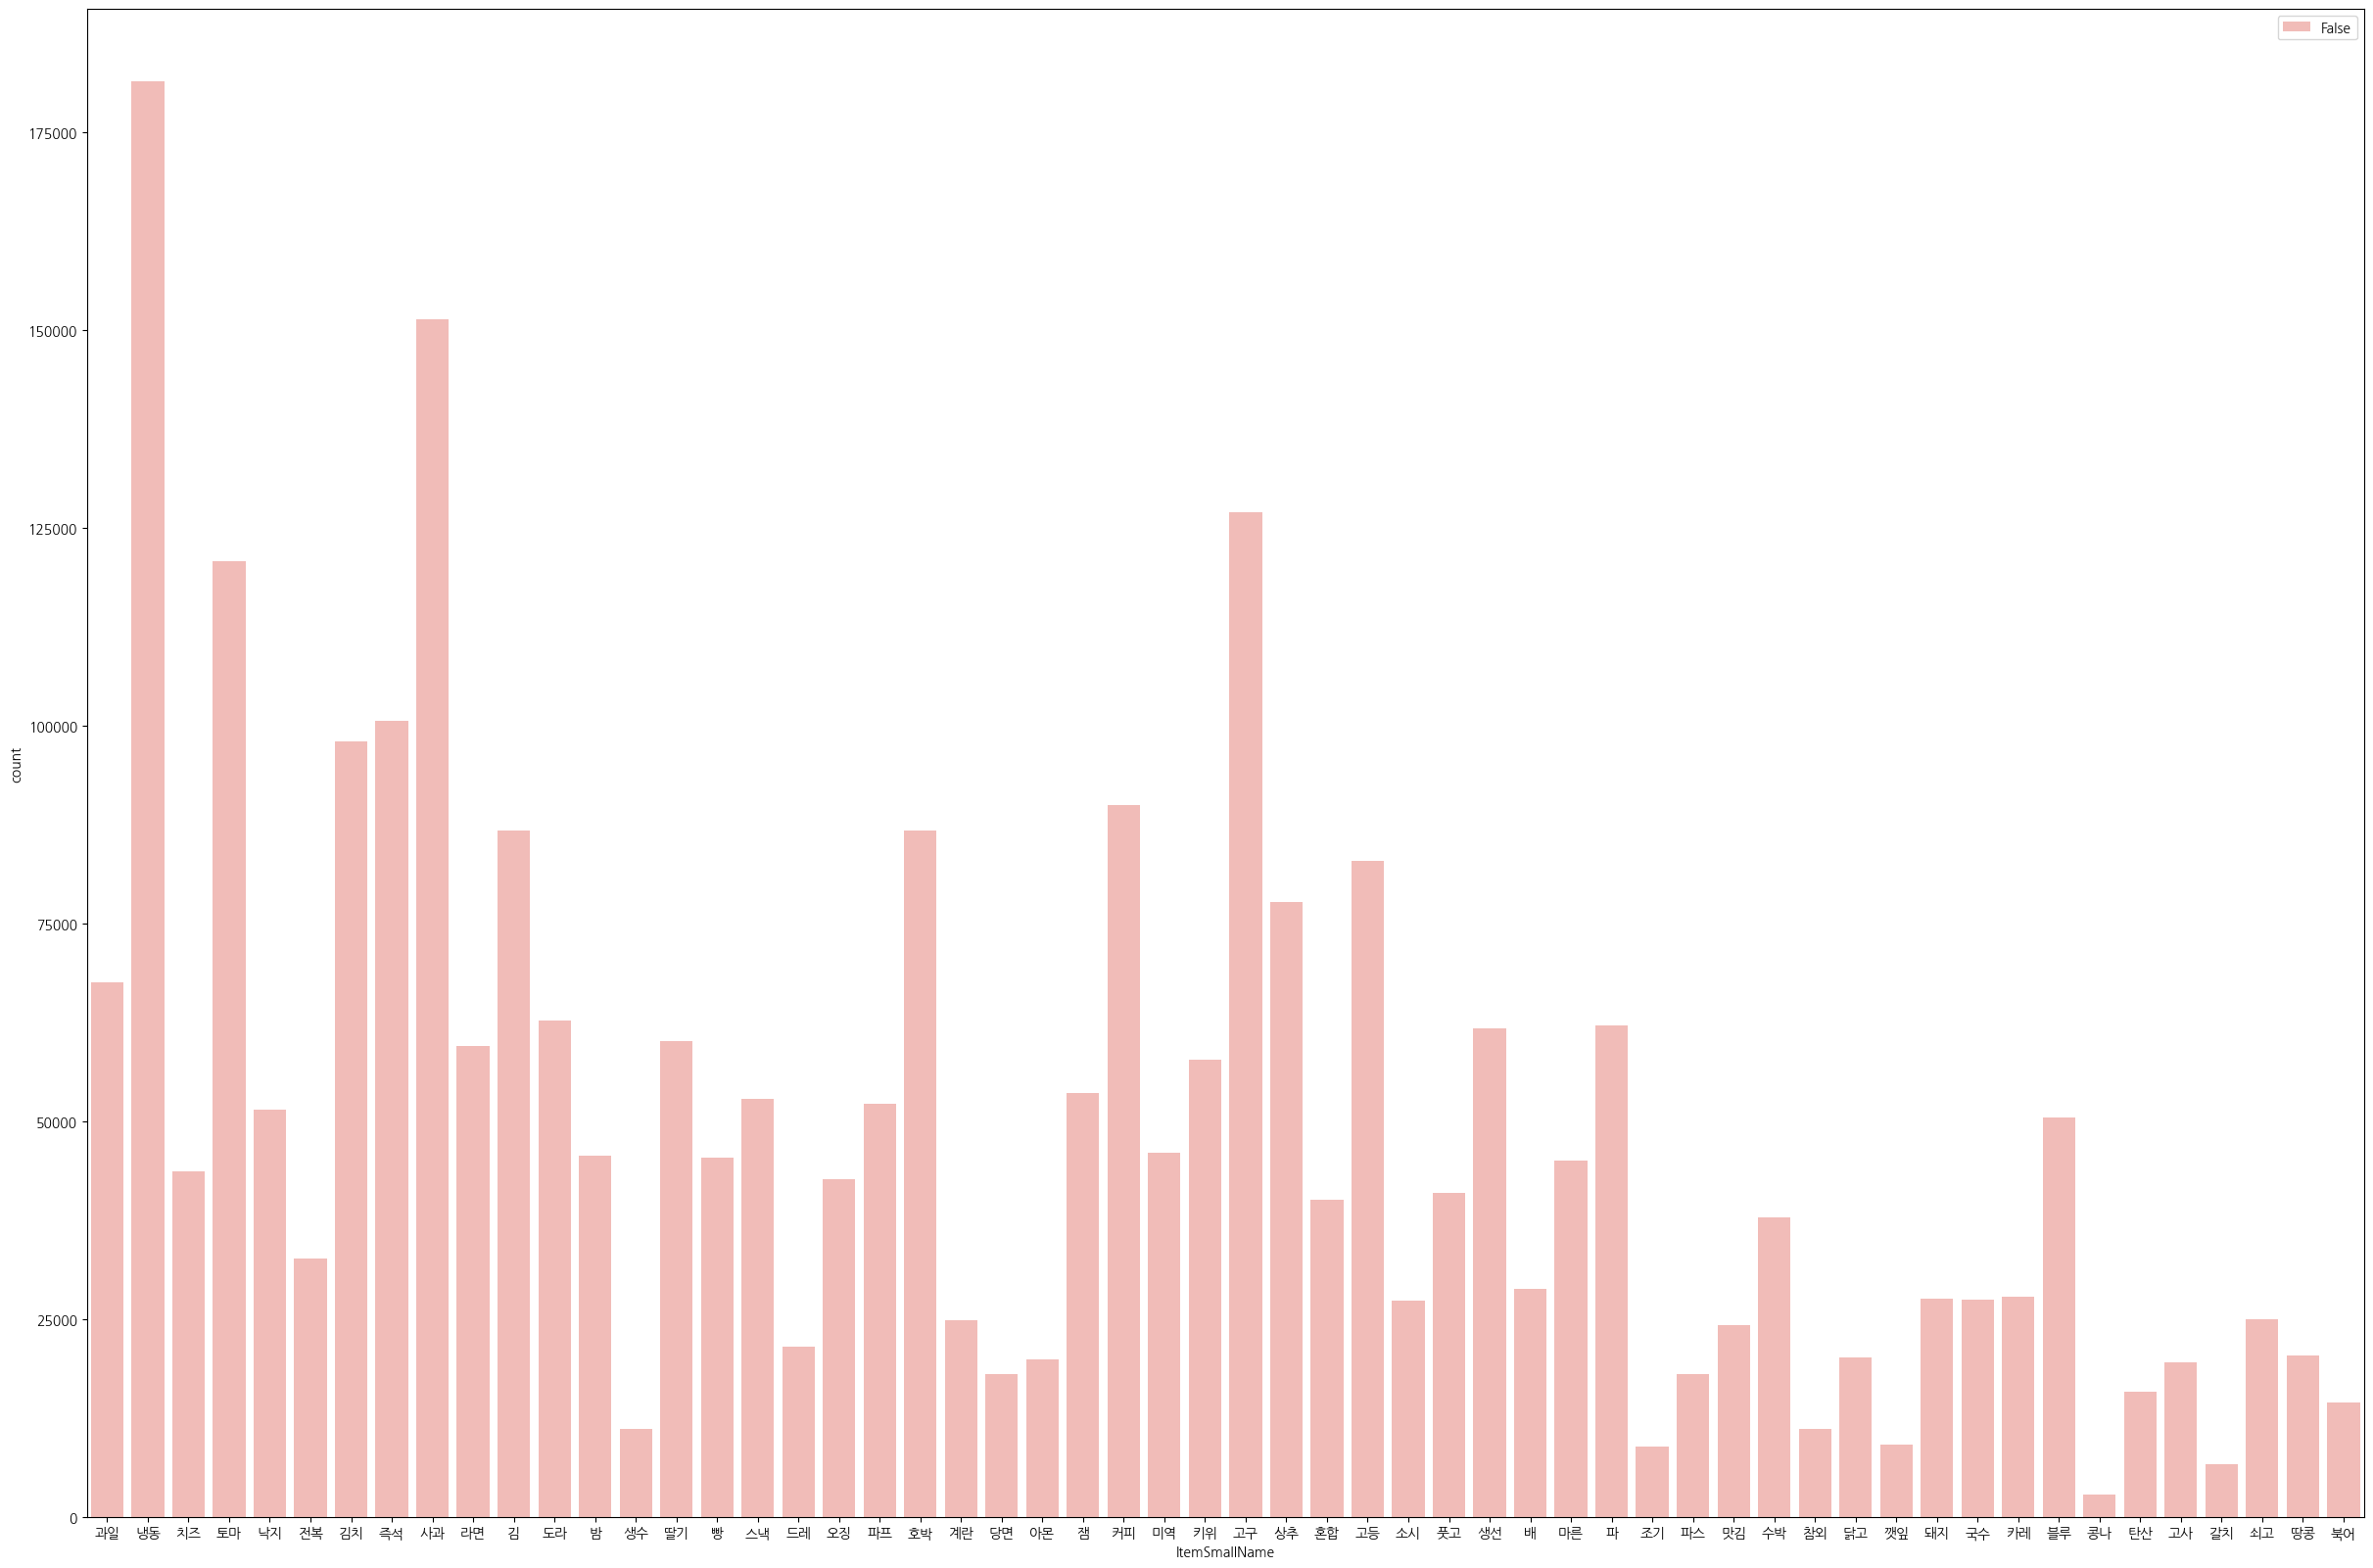

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'AgeGroup'=='[30s]')

<Axes: xlabel='ItemSmallName', ylabel='count'>

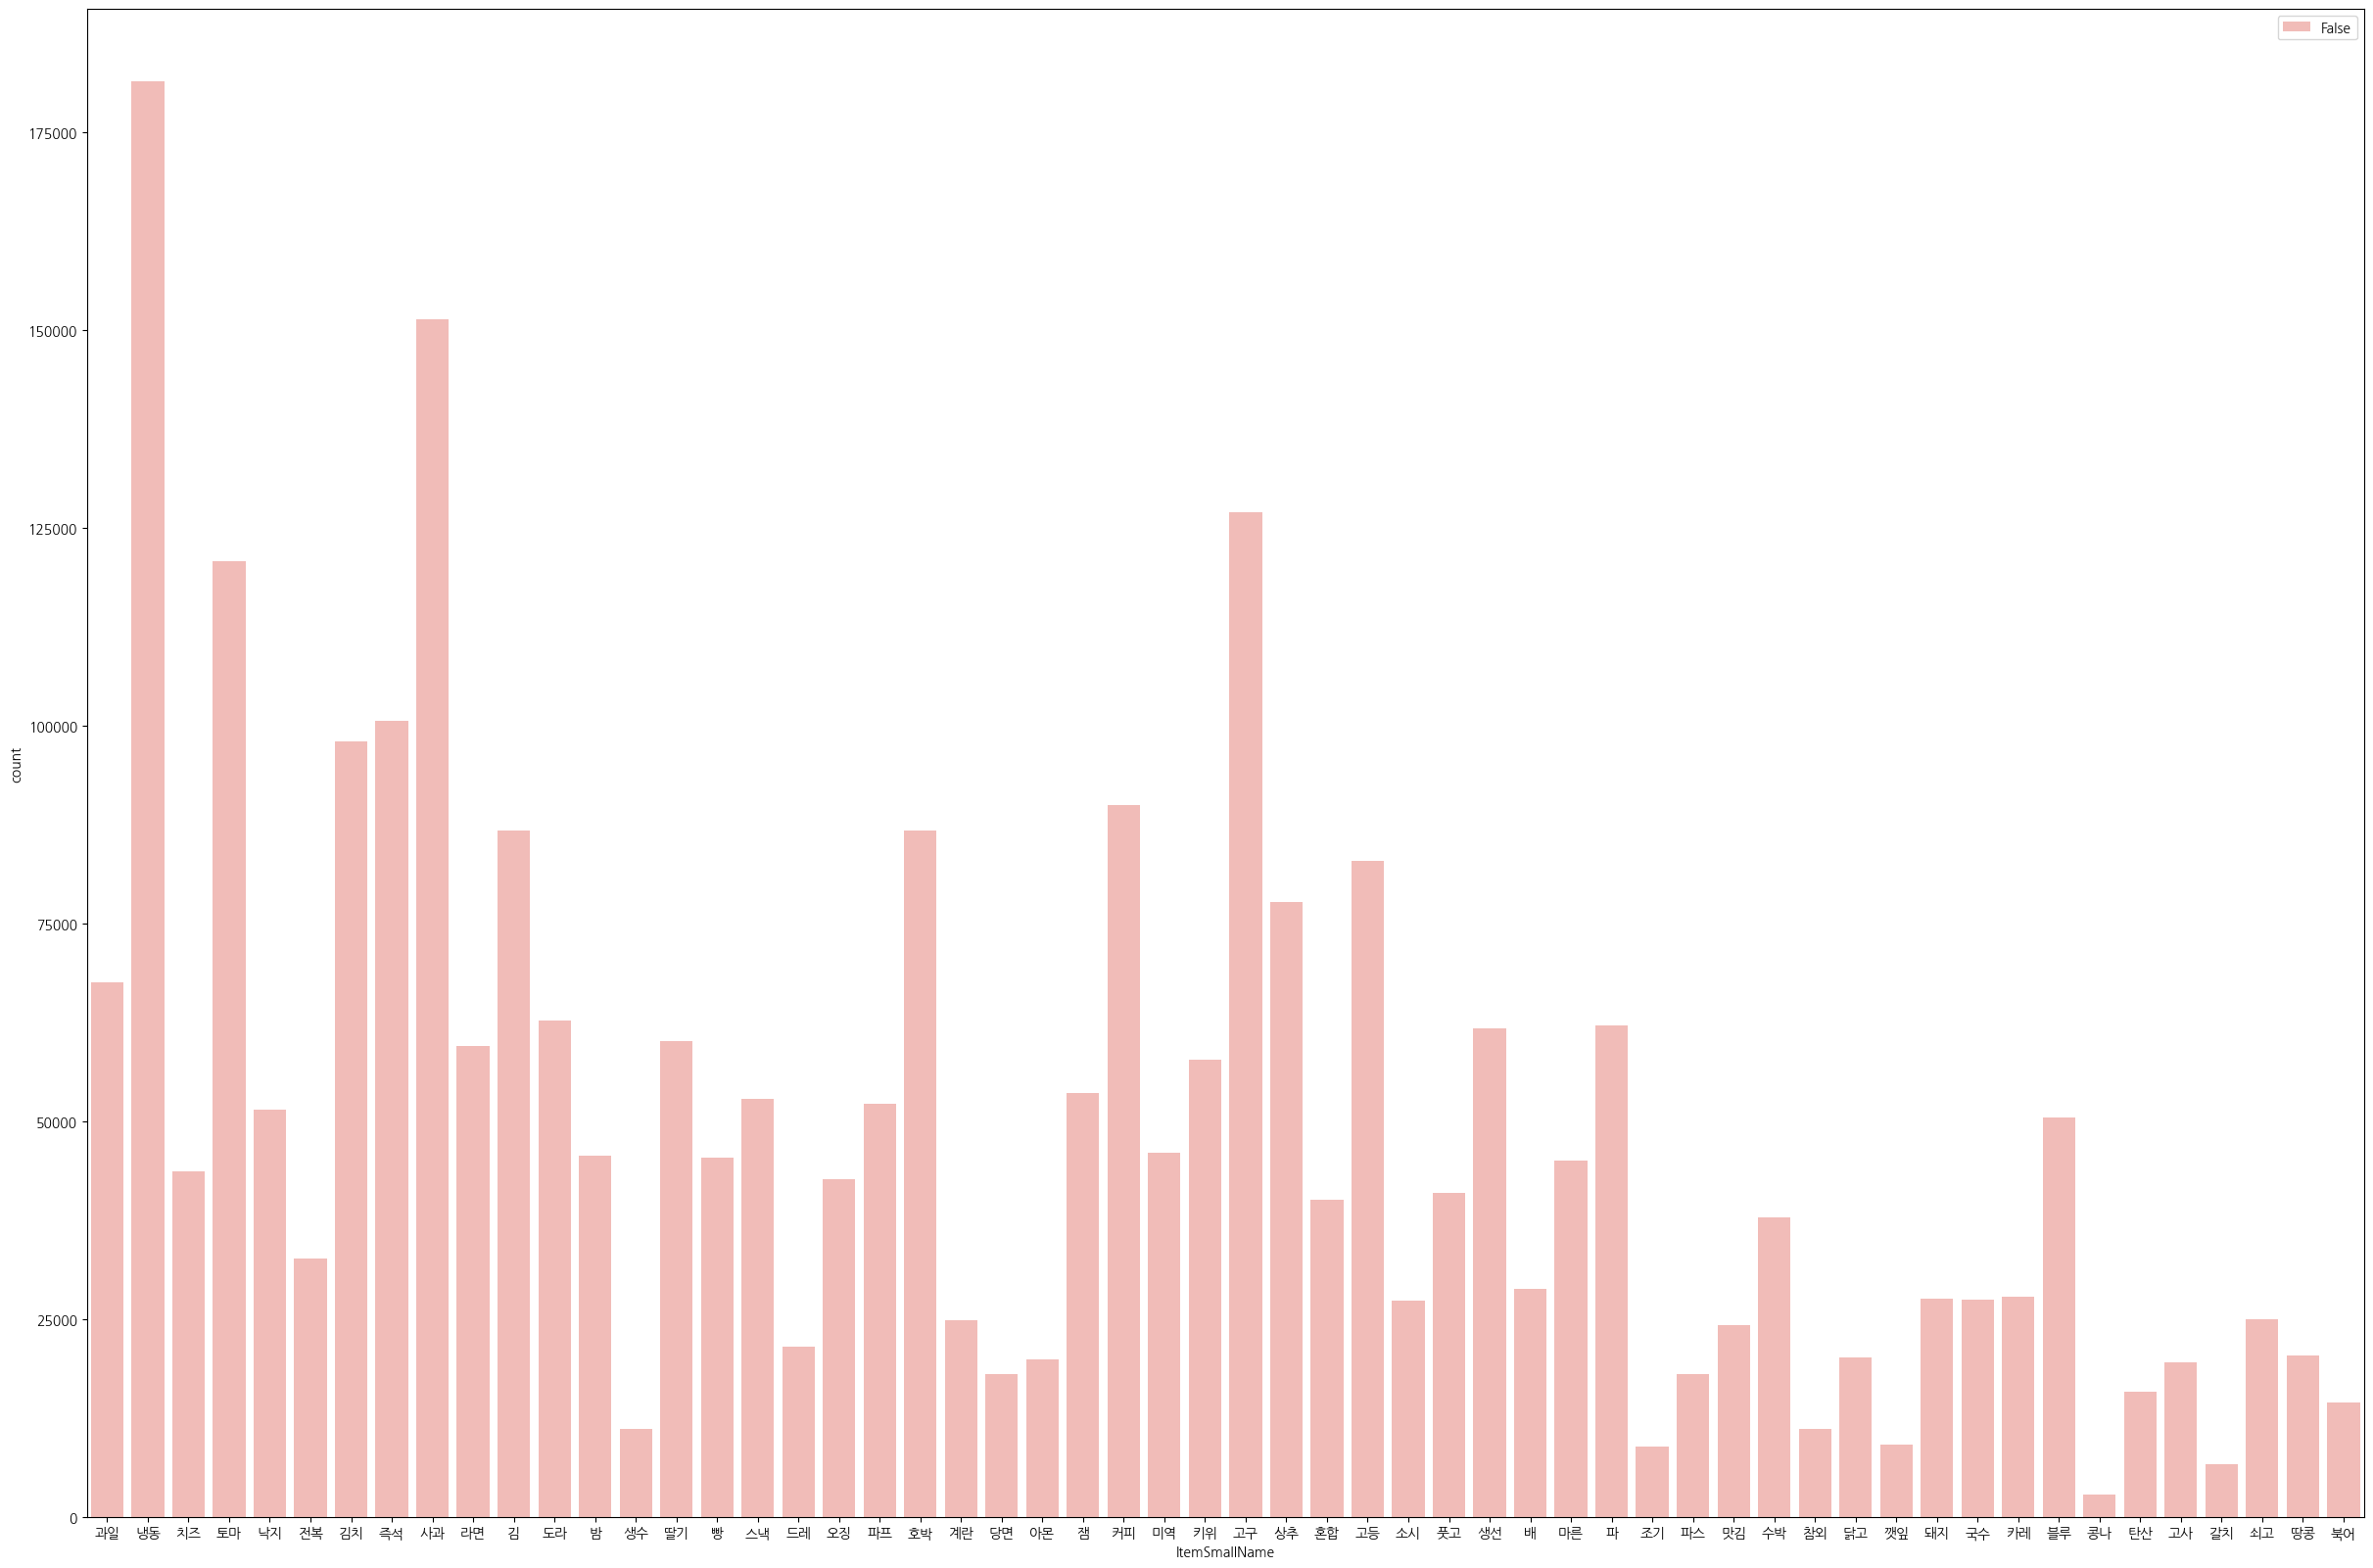

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'AgeGroup'=='[40s]')

<Axes: xlabel='ItemSmallName', ylabel='count'>

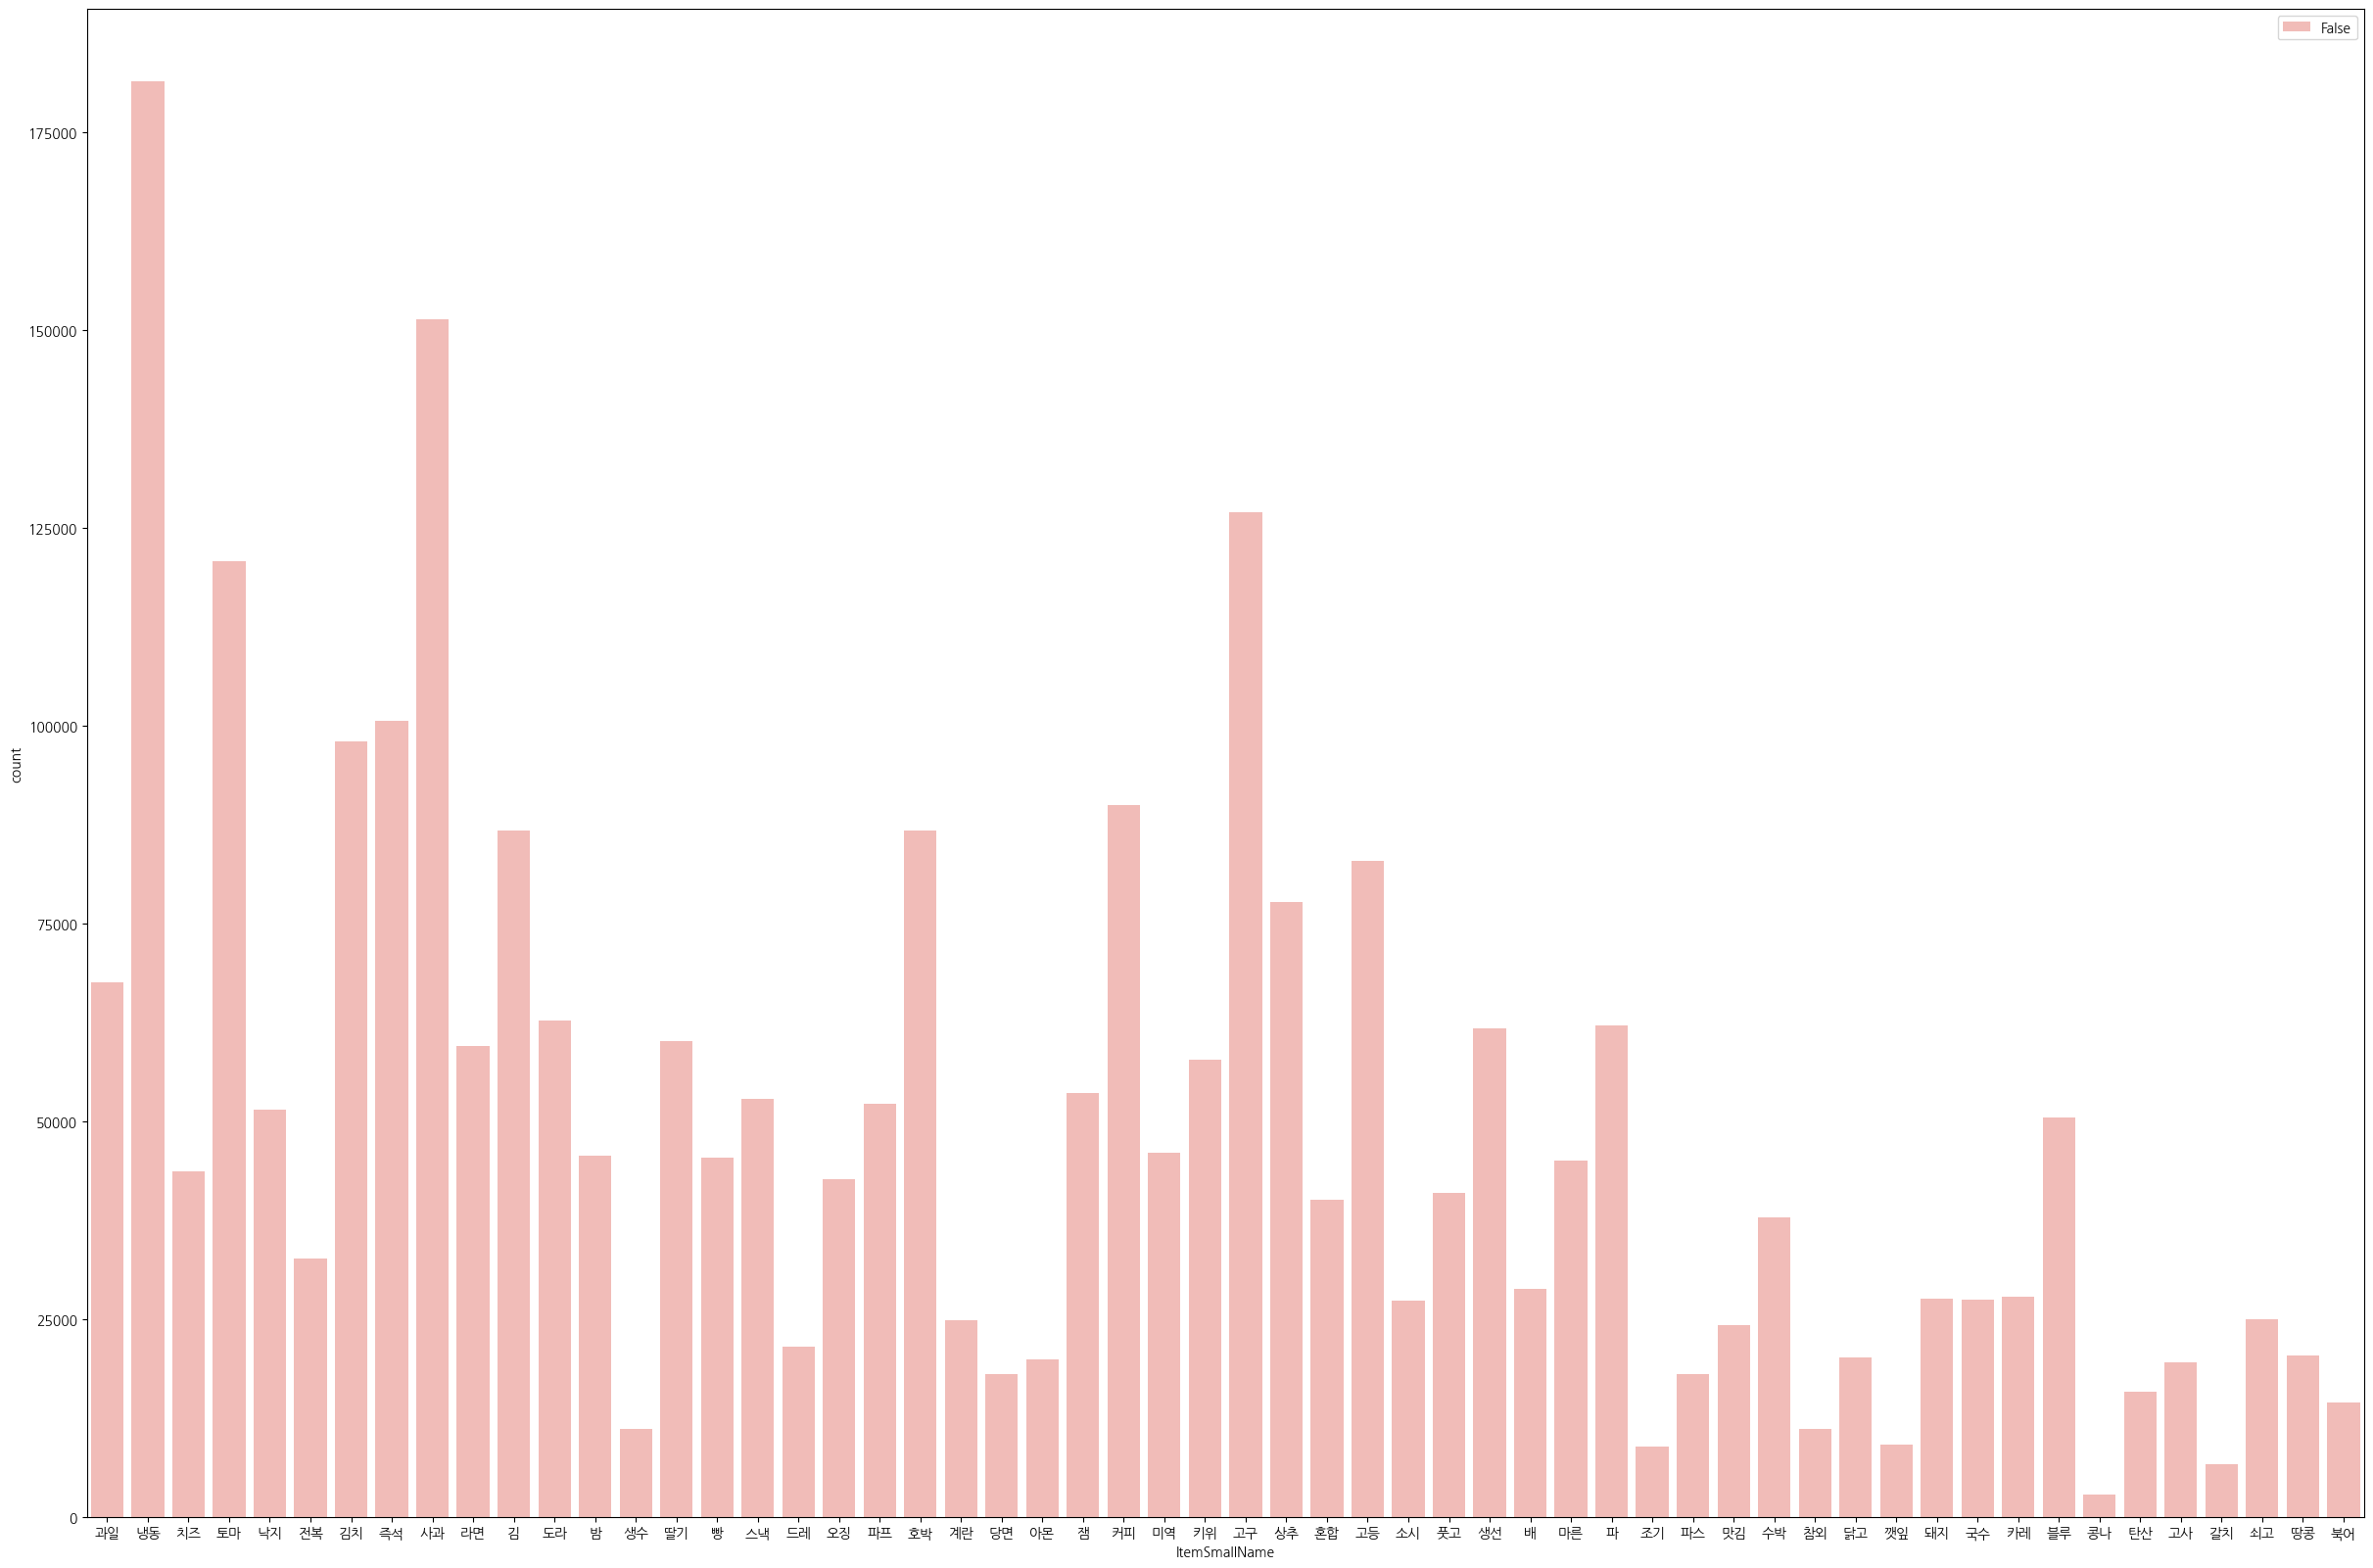

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'AgeGroup'=='[50s]')

<Axes: xlabel='ItemSmallName', ylabel='count'>

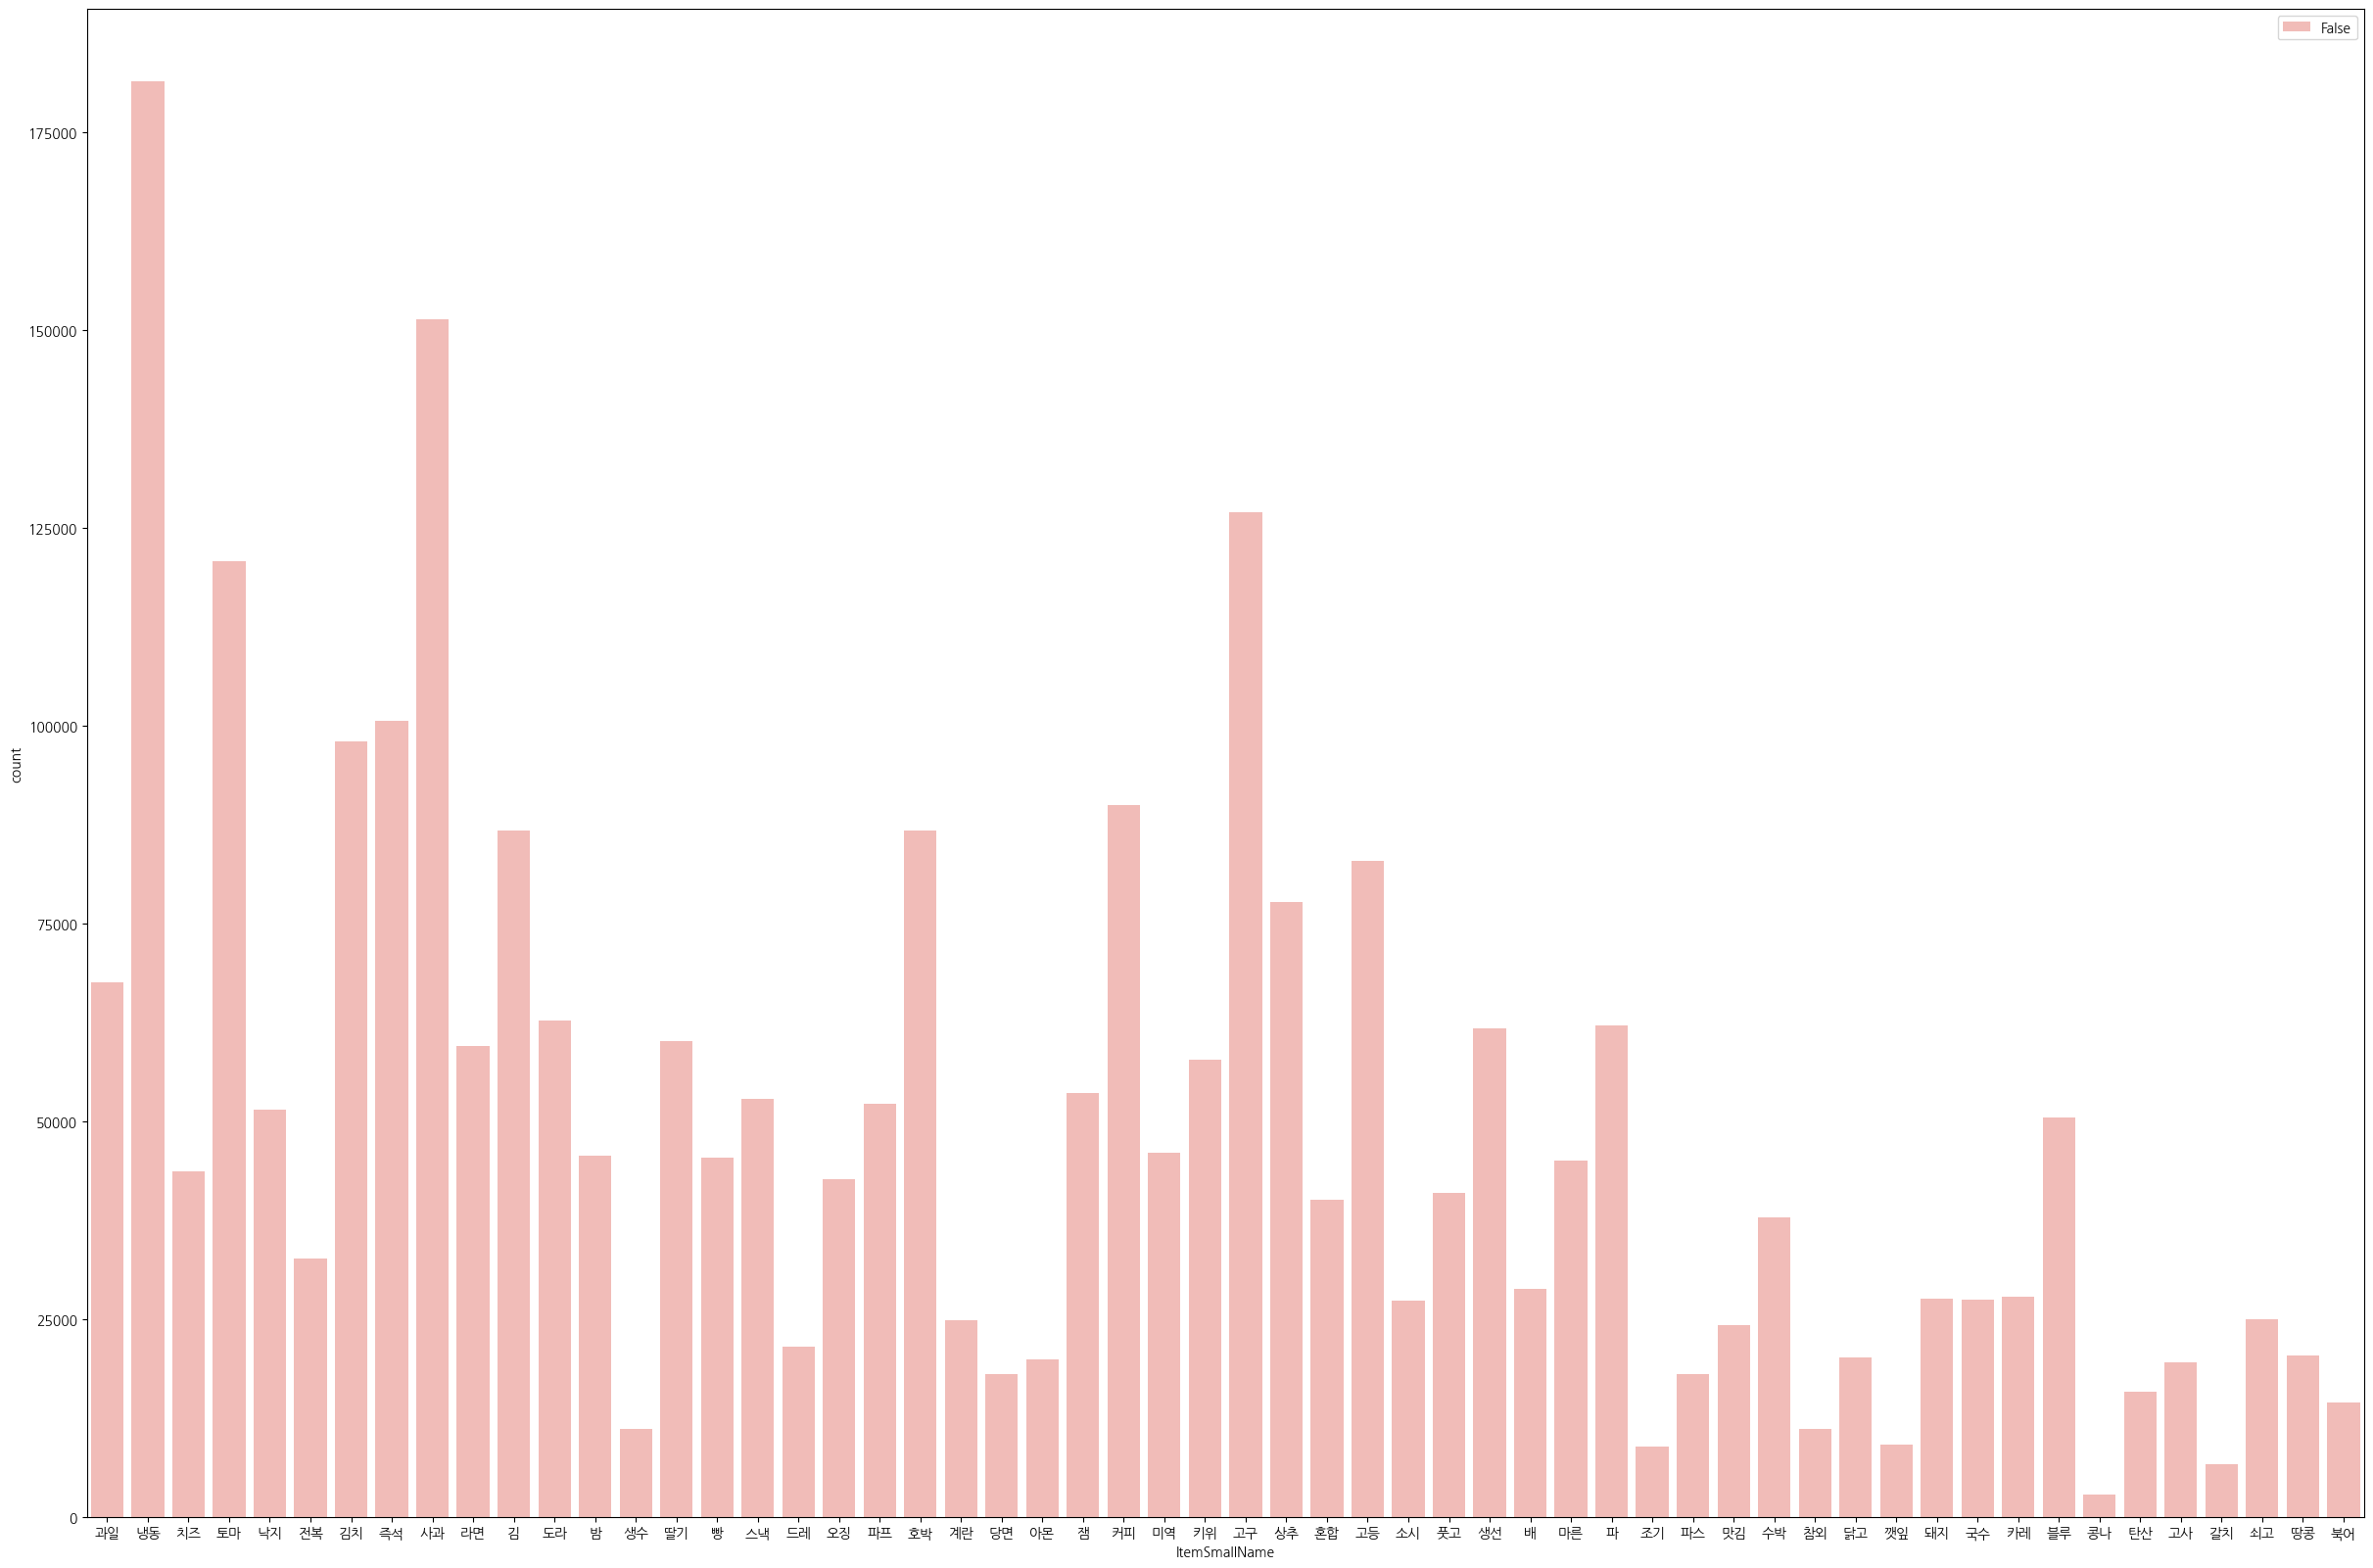

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'FamilyCount'=='[0]')

<Axes: xlabel='ItemSmallName', ylabel='count'>

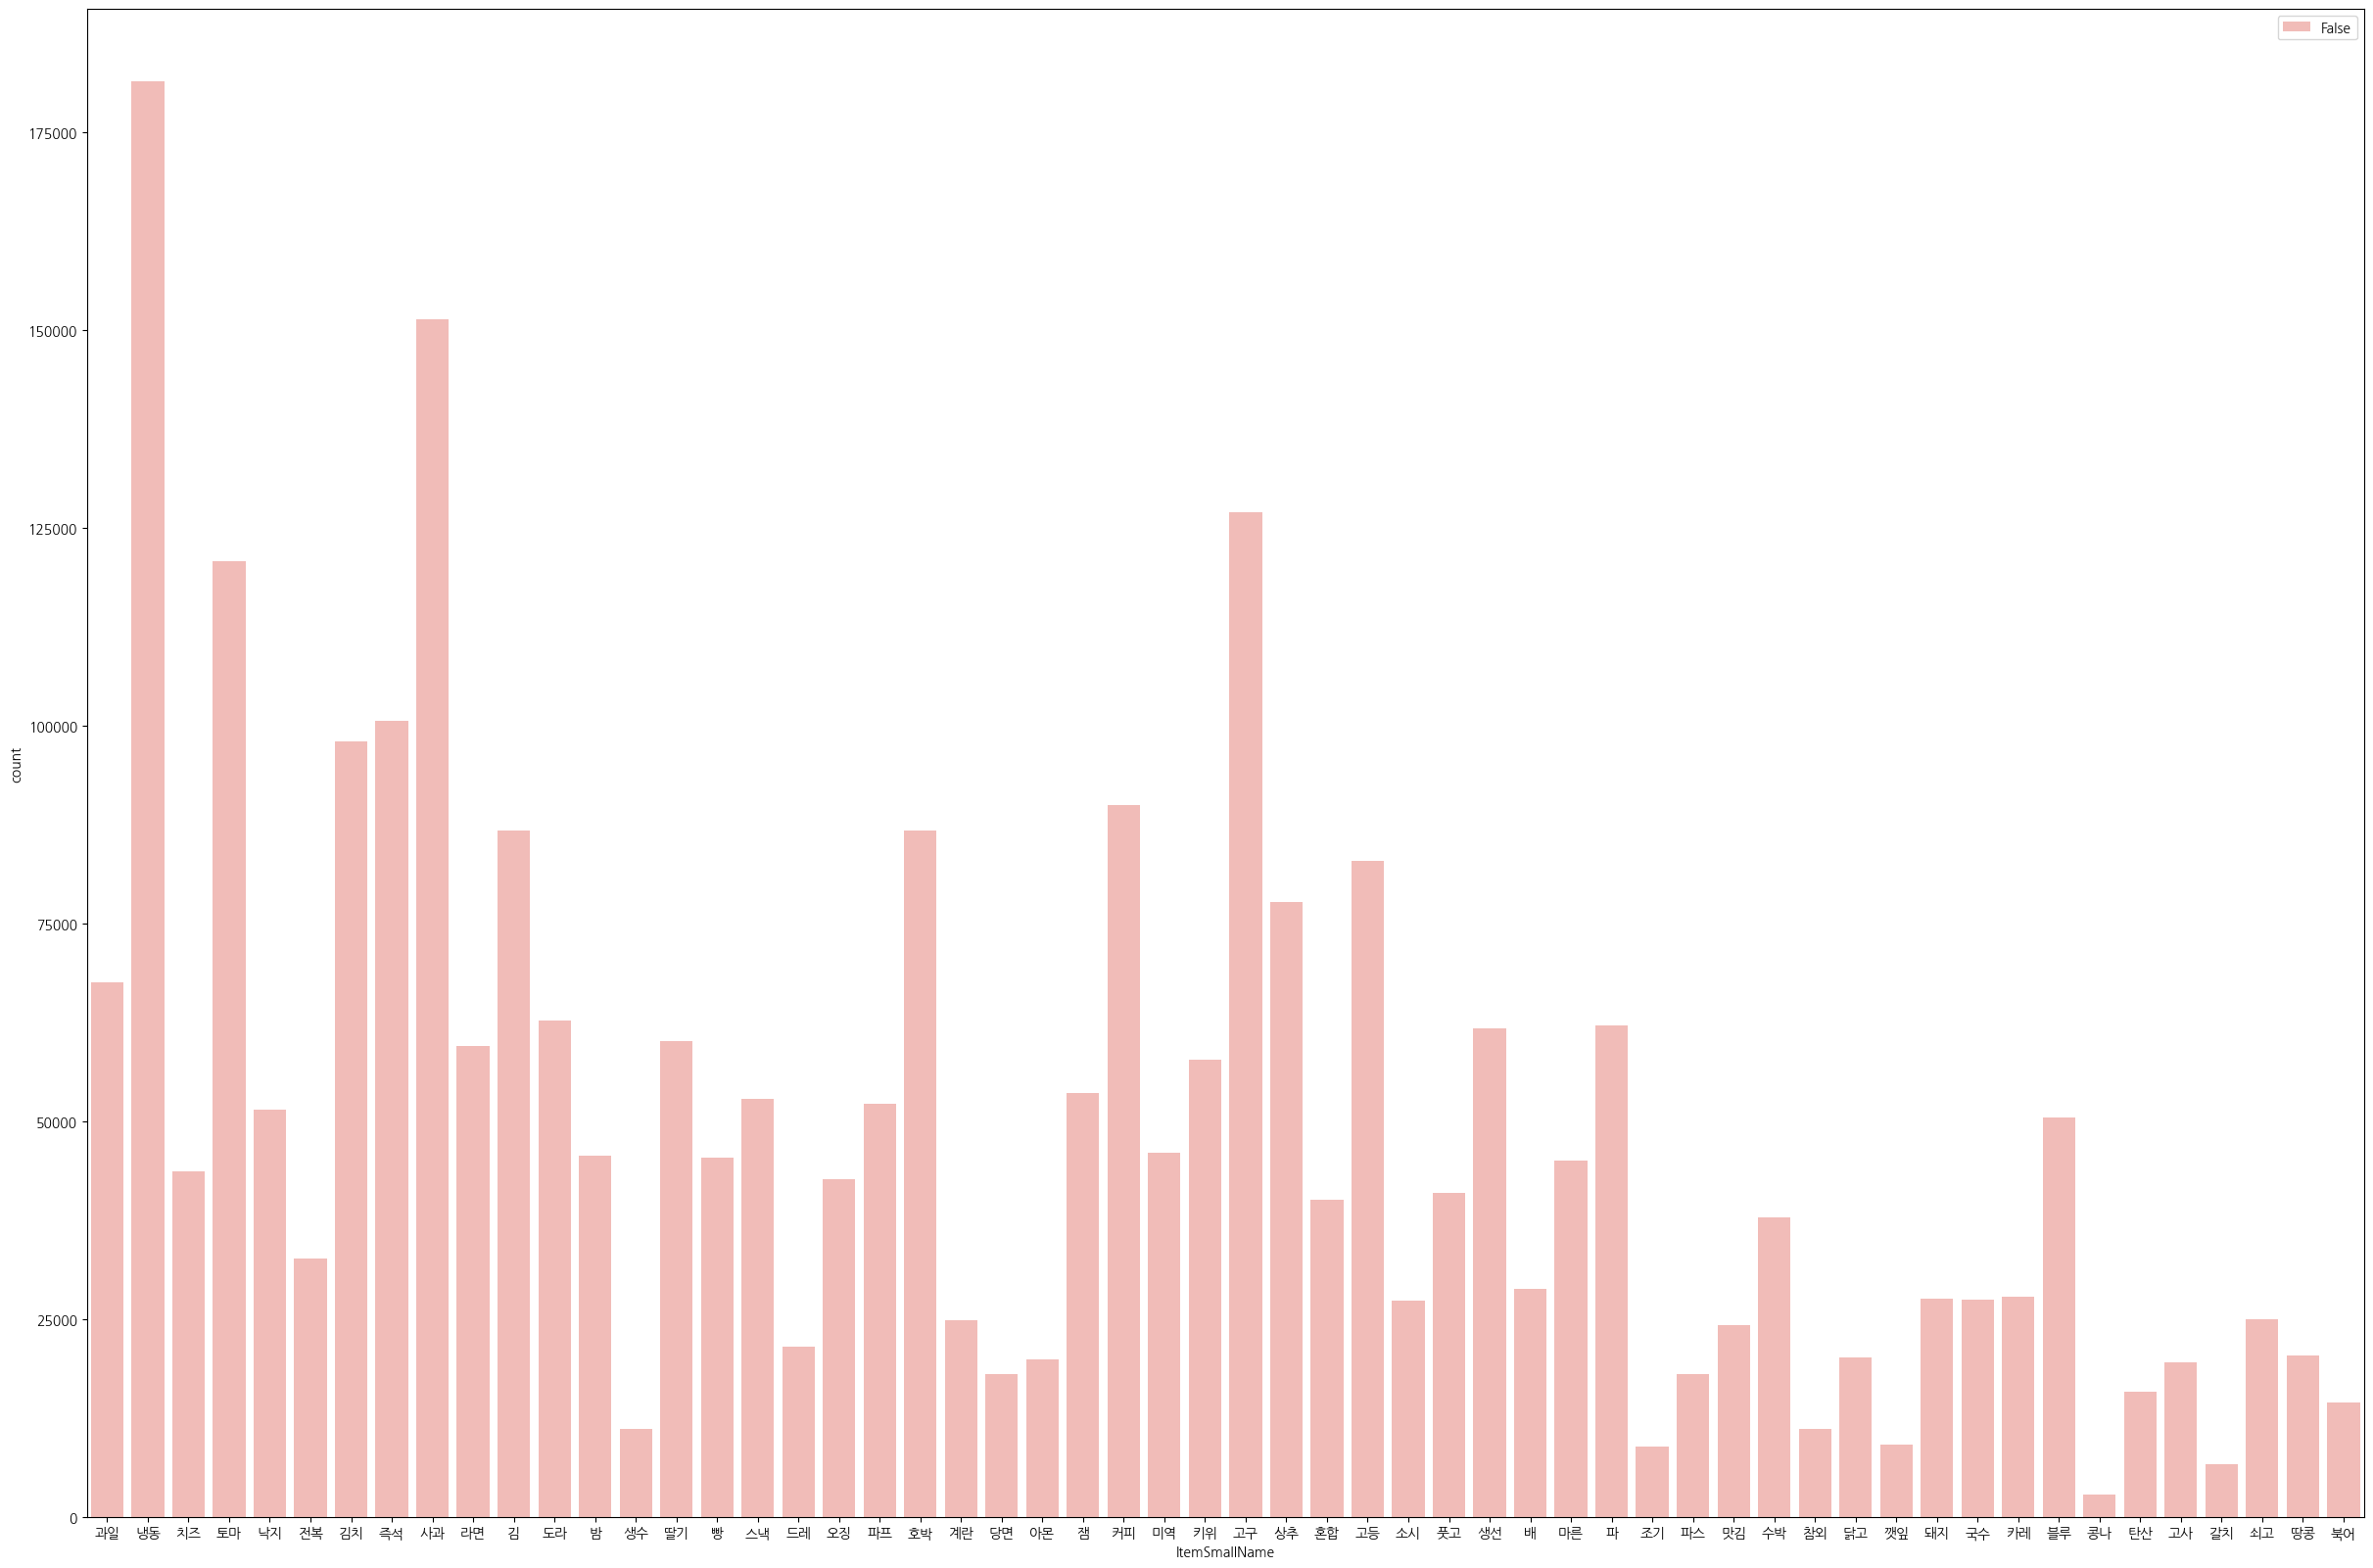

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'FamilyCount'=='[3]')

<Axes: xlabel='ItemSmallName', ylabel='count'>

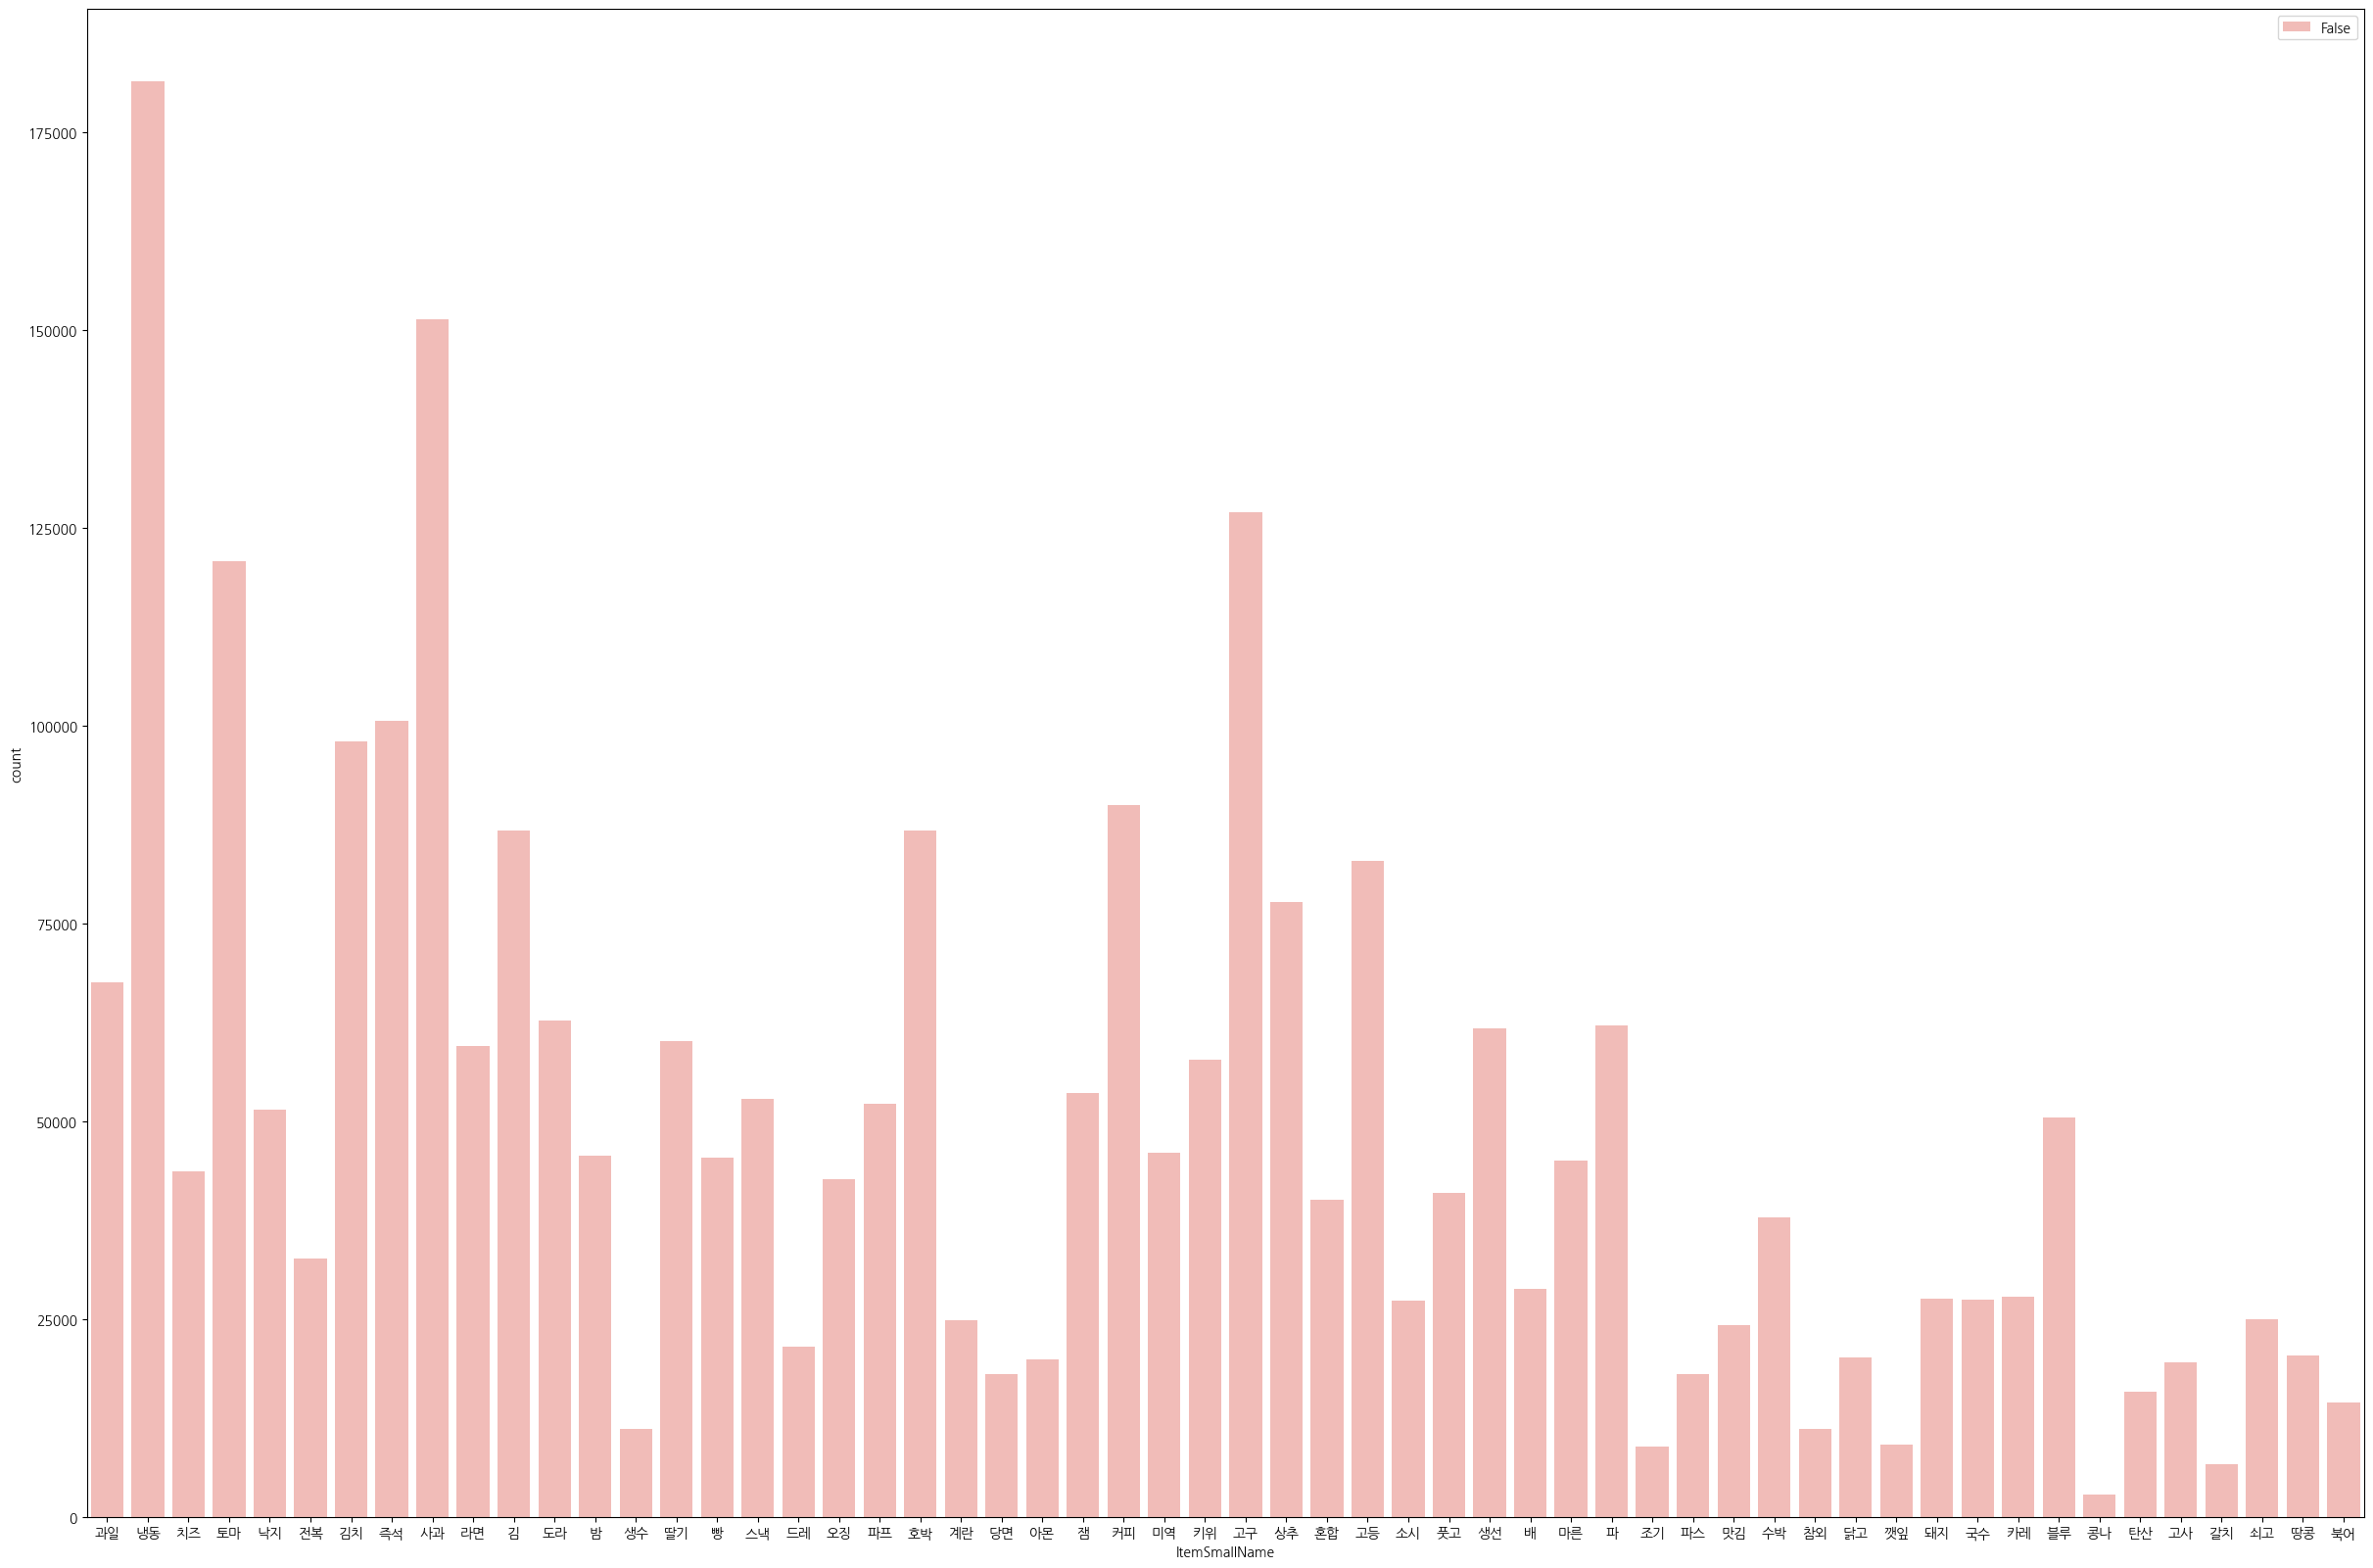

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'AgeGroup'==['여성'])

<Axes: xlabel='ItemSmallName', ylabel='count'>

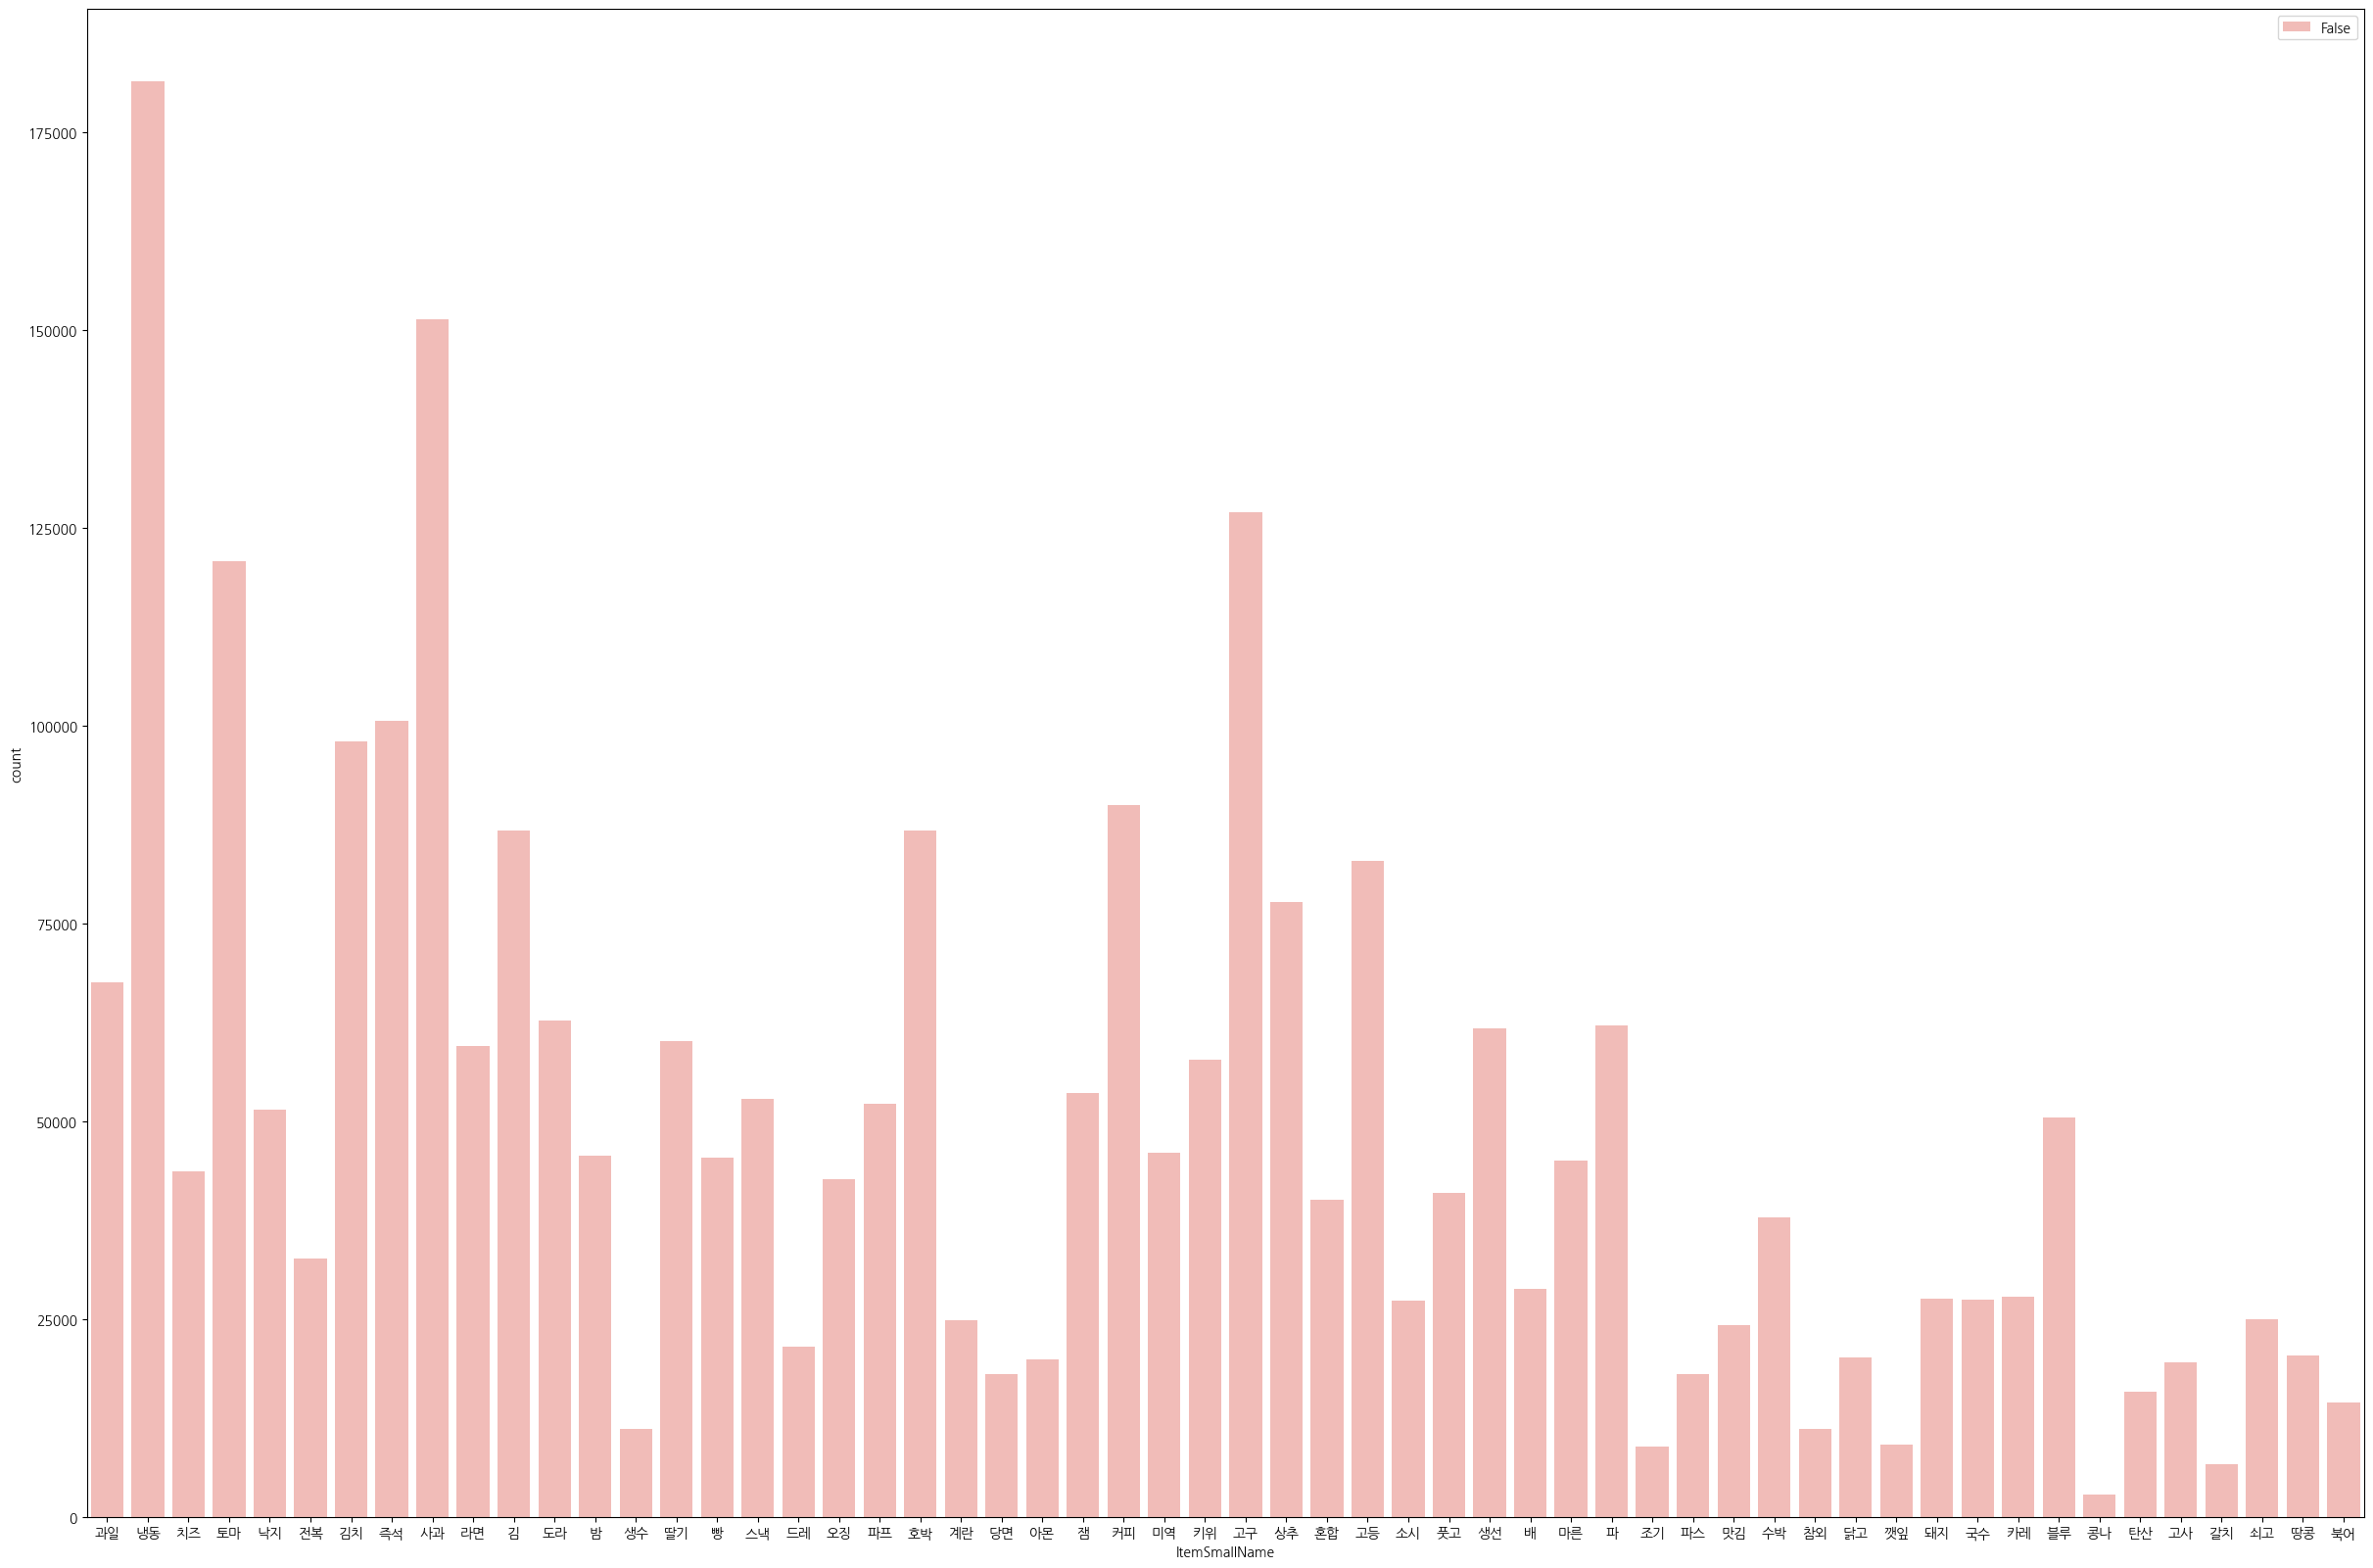

In [ ]:
plt.figure(figsize=(30, 20))
sns.countplot(data = data, x='ItemSmallName', hue = 'AgeGroup'==['남성'])

In [ ]:
# 예시 코드
grouped = data.groupby(['AgeGroup', 'Gender', 'FamilyCount', 'ItemSmallName']).size().reset_index(name='Count')
top_10_per_combination = grouped.sort_values(by=['AgeGroup', 'Gender', 'FamilyCount', 'Count'], ascending=[True, True, True, False])
top_10_per_combination = top_10_per_combination.groupby(['AgeGroup', 'Gender', 'FamilyCount']).head(10)
# 'Combination' 컬럼 생성 전에 Categorical 타입을 str 타입으로 변환
top_10_per_combination['AgeGroup'] = top_10_per_combination['AgeGroup'].astype(str)
top_10_per_combination['Gender'] = top_10_per_combination['Gender'].astype(str)
top_10_per_combination['FamilyCount'] = top_10_per_combination['FamilyCount'].astype(str)

# 이제 안전하게 문자열 결합을 수행할 수 있습니다.
top_10_per_combination['Combination'] = top_10_per_combination['AgeGroup'] + ', ' + top_10_per_combination['Gender'] + ', ' + top_10_per_combination['FamilyCount']

sorted_top_10_items = top_10_per_combination.sort_values(by='Count', ascending=False)

sorted_top_10_items.head(20)


,AgeGroup,Gender,FamilyCount,ItemSmallName,Count,Combination
795,30s,여성,2,냉동,16636,"30s, 여성, 2"
812,30s,여성,2,사과,14120,"30s, 여성, 2"
851,30s,여성,3,냉동,12960,"30s, 여성, 3"
515,30s,남성,1,냉동,11922,"30s, 남성, 1"
786,30s,여성,2,고구,11738,"30s, 여성, 2"
833,30s,여성,2,토마,11422,"30s, 여성, 2"
571,30s,남성,2,냉동,11014,"30s, 남성, 2"
868,30s,여성,3,사과,10828,"30s, 여성, 3"
347,20s,여성,2,냉동,10478,"20s, 여성, 2"
532,30s,남성,1,사과,9590,"30s, 남성, 1"


In [ ]:
grouped = data.groupby(['AgeGroup', 'Gender', 'FamilyCount', 'ItemSmallName']).size().reset_index(name='Count')
grouped['Rank'] = grouped.groupby(['AgeGroup', 'Gender', 'FamilyCount'])['Count'].rank(method='first', ascending=False)

# 각 그룹별 상위 10개의 ItemSmallName을 선택합니다.
top_10_per_combination = grouped[grouped['Rank'] <= 10]

# 조합 컬럼을 생성합니다.
top_10_per_combination['Combination'] = top_10_per_combination['AgeGroup'].astype(str) + "_" + top_10_per_combination['Gender'].astype(str) + "_" + top_10_per_combination['FamilyCount'].astype(str)

# 피벗 테이블을 생성합니다. 이 때, 순위를 행으로, 조합을 열로, 그리고 값으로는 ItemSmallName을 사용합니다.
pivot = top_10_per_combination.pivot(index='Rank', columns='Combination', values='ItemSmallName').fillna('')

print(pivot)


Combination 20s_남성_0 20s_남성_1 20s_남성_2 20s_남성_3 20s_여성_0 20s_여성_1 20s_여성_2  \
Rank                                                                         
1.0               냉동       냉동       냉동       냉동       냉동       냉동       냉동   
2.0               사과       사과       사과       사과       사과       사과       사과   
3.0               고구       고구       고구       고구       토마       고구       고구   
4.0               토마       토마       토마       토마       고구       토마       토마   
5.0               김치       즉석       김치       김치       즉석       즉석       즉석   
6.0               즉석       김치       즉석       즉석       김치       김치       호박   
7.0               커피       호박       호박       커피       커피       커피       김치   
8.0                김       커피        김        김       호박        김       커피   
9.0               고등        김       커피       호박       고등       호박        김   
10.0              호박       고등       상추       고등        김       고등       고등   

Combination 20s_여성_3 30s_남성_0 30s_남성_1  ... 50s_여성_2 50s_여성_3 6

In [ ]:
data[data['idUser']=='U10251']['ItemSmallName'].value_counts()

사과    11
김     11
냉동     9
파      9
잼      9
즉석     8
김치     6
탄산     6
전복     5
소시     5
마른     4
호박     4
블루     4
생수     4
낙지     3
땅콩     3
딸기     3
풋고     3
카레     3
계란     3
밤      3
드레     3
파프     3
치즈     3
상추     3
쇠고     3
토마     3
당면     3
커피     3
미역     2
파스     2
과일     2
고구     2
생선     2
Name: ItemSmallName, dtype: int64

   idUser            idOrder             OrderDT           ItemCode  Price  \
0  U10001  U10001-O2021-1001 2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
1  U10001  U10001-O2021-1001 2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
2  U10001  U10001-O2021-1001 2021-12-03 20:59:27  L1-M12-S0070-1113  17030   
3  U10047  U10047-O2021-1027 2021-02-02 14:07:24  L1-M12-S0070-1113  17300   
4  U10047  U10047-O2021-1027 2021-02-02 14:07:24  L1-M12-S0070-1113  17300   

           DeliveryDT Gender  Age  FamilyCount MemberYN  ... ItemLargeName  \
0  04DEC2021:03:26:00     여성   26            2        Y  ...          가공식품   
1  04DEC2021:03:26:00     여성   26            2        Y  ...          가공식품   
2  04DEC2021:03:26:00     여성   26            2        Y  ...          가공식품   
3  03FEB2021:03:17:00     남성   55            0        Y  ...          가공식품   
4  03FEB2021:03:17:00     남성   55            0        Y  ...          가공식품   

   ItemMiddleCode  ItemMiddleName  ItemSmallCode  ItemSmallNam